## **ABCDEats Company - Customer Segmentation**

![Alt Text](https://www.coforge.com/hubfs/Imported_Blog_Media/Screenshot-2022-01-20-at-12_18_26-1024x294-1-1.png)


**Notebook 6:  Evaluation**

We are now at stage 5: Int his step, we will evaluate the selected algorithms by the merged perspectives.

# Table of Contents

1. [Imports](#Imports)
    
2. [Scaling](#Scaling)
    1. [RobustScaler](##RobustScaler)
3. [Persperctives](#Perspectives)
    1. [Merging the perspectives](##Merging-the-Perspectives)
        1. [Manually Merging the perspectives](##Manually-Merging-the-Perspectives)
        1. [Merging using the Hierarchical clustering](##Merging-using-the-Hierarchical-clustering)
4. [Cluster visualization with t-ne](#Cluster-visualization-with-t-ne)
    1. [Scores](##Scores)
5. [Feature Importance](#Feature-Importance)
    1. [Using the R2](##Using-the-R2)
    1. [Using the Decision Tree](##Using-the-decision-tree)
6. [Categorical Features](#Categorical-Features)

# Imports

In [96]:
# Importing necessary libraries for analysis

# Data manipulation and computation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from IPython.display import display
import matplotlib.cm as cm

# Clustering and dimensionality reduction
from sklearn.cluster import KMeans, AgglomerativeClustering, MeanShift, estimate_bandwidth
from sklearn.metrics import silhouette_score, silhouette_samples, calinski_harabasz_score, pairwise_distances
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram

#Feature evaluation
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

# Scaling and preprocessing
from sklearn.preprocessing import MinMaxScaler, RobustScaler

# Statistical analysis
from scipy.stats import chi2_contingency
import scipy.stats as stats

# Utilities
import os
from os.path import join
from math import ceil
from itertools import product

# Extras
import warnings
warnings.filterwarnings("ignore")
%config InlineBackend.figure_format = 'retina'  # for better resolution plots
sns.set()
pd.set_option('display.max_columns', None)


## Data Importing


In [97]:
#Importing our dataset into a variable "food_df"

food_df = pd.read_csv("../Data/food_df_preprocessed.csv")

In [98]:
#Setting the customer region to object, to make sure it does not go as an int
food_df['customer_region'] = food_df['customer_region'].astype('object')

In [99]:
#Getting the numeical features
food_numerical = food_df.select_dtypes(exclude="object")

In [100]:
food_numerical = (food_numerical.columns).tolist()

In [101]:
food_df_scale = food_df.copy()

>Defining the color palette

In [102]:
#Defining the colors for our graphs
colors = {
    "R": "#F5979D", #light red
    "BL": "#0a9ea3", #cyan blue
    "BR": "#4F323D", #brown
    "P": "#6947ad" ,   # Purple
    "G": "#099c52",  #spring green
    "B": "#9cc5d9",  #light blue
    "Y": "#d69231",   #Yellow
    "M": "#960b50",   # some kind of pink
    "PR": "#ad474c"  #Weird red
}
custom_palette = list(colors.values())


>These are functions that may be used thoughout the notebook.

In [103]:
def get_ss(df, feats):
    """
    Calculate the sum of squares (SS) for the given DataFrame.

    The sum of squares is computed as the sum of the variances of each column
    multiplied by the number of non-NA/null observations minus one.

    Parameters:
    df (pandas.DataFrame): The input DataFrame for which the sum of squares is to be calculated.
    feats (list of str): A list of feature column names to be used in the calculation.

    Returns:
    float: The sum of squares of the DataFrame.
    """
    df_ = df[feats]
    ss = np.sum(df_.var() * (df_.count() - 1))
    
    return ss 


def get_ssb(df, feats, label_col):
    """
    Calculate the between-group sum of squares (SSB) for the given DataFrame.
    The between-group sum of squares is computed as the sum of the squared differences
    between the mean of each group and the overall mean, weighted by the number of observations
    in each group.

    Parameters:
    df (pandas.DataFrame): The input DataFrame containing the data.
    feats (list of str): A list of feature column names to be used in the calculation.
    label_col (str): The name of the column in the DataFrame that contains the group labels.
    
    Returns
    float: The between-group sum of squares of the DataFrame.
    """
    
    ssb_i = 0
    for i in np.unique(df[label_col]):
        df_ = df.loc[:, feats]
        X_ = df_.values
        X_k = df_.loc[df[label_col] == i].values
        
        ssb_i += (X_k.shape[0] * (np.square(X_k.mean(axis=0) - X_.mean(axis=0))) )

    ssb = np.sum(ssb_i)
    

    return ssb


def get_ssw(df, feats, label_col):
    """
    Calculate the sum of squared within-cluster distances (SSW) for a given DataFrame.

    Parameters:
    df (pandas.DataFrame): The input DataFrame containing the data.
    feats (list of str): A list of feature column names to be used in the calculation.
    label_col (str): The name of the column containing cluster labels.

    Returns:
    float: The sum of squared within-cluster distances (SSW).
    """
    feats_label = feats+[label_col]


    df_k = df[feats_label].groupby(by=label_col).apply(
    lambda col: get_ss(col, feats)
    )

    return df_k.sum()



In [104]:
def get_rsq(df, feats, label_col):
    """
    Calculate the R-squared value for a given DataFrame and features.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing the data.
    feats (list): A list of feature column names to be used in the calculation.
    label_col (str): The name of the column containing the labels or cluster assignments.

    Returns:
    float: The R-squared value, representing the proportion of variance explained by the clustering.
    """

    df_sst_ = get_ss(df, feats)                 # get total sum of squares
    df_ssw_ = get_ssw(df, feats, label_col)     # get ss within
    df_ssb_ = df_sst_ - df_ssw_                 # get ss between

    # r2 = ssb/sst 
    return (df_ssb_/df_sst_)

In [105]:
def get_r2_scores(df, feats, clusterer, min_k=2, max_k=10):
    """
    Loop over different values of k. To be used with sklearn clusterers.
    """
    r2_clust = {}
    for n in range(min_k, max_k):
        clust = clone(clusterer).set_params(n_clusters=n)
        labels = clust.fit_predict(df)
        df_concat = pd.concat([df, 
                               pd.Series(labels, name='labels', index=df.index)], axis=1)  

        r2_clust[n] = get_rsq(df_concat, feats, 'labels' )
    return r2_clust



# Scaling

> It is crucial to apply some scalling to our entire dataset because we are working with features with different ranges. <br>
> Since our data still exhibits some skewness, it's important to choose a scaling method that is robust to such non-normal distributions. <br>
> For this we chose `Robust Scaler`.

### RobustScaler

In [106]:
scaler = RobustScaler()
food_df_scale_features = scaler.fit_transform(food_df_scale[food_numerical])
food_df_scale_features

array([[ 0.        ,  0.10342103, -0.70105028, ..., -0.63157895,
         0.64516129,  0.87209302],
       [ 0.        , -0.62210225,  0.26882505, ...,  0.07823613,
         0.64516129,  0.87209302],
       [ 0.        , -0.03986614, -0.70105028, ..., -0.86344239,
         0.64516129,  0.87209302],
       ...,
       [ 0.5       , -0.62210225,  0.61322149, ...,  0.79516358,
        -1.96774194, -1.06395349],
       [-0.5       ,  0.39773793,  0.27438073, ...,  0.12802276,
        -1.96774194, -1.06395349],
       [-0.5       , -0.62210225, -0.13857705, ..., -0.6970128 ,
        -1.96774194, -0.90697674]])

In [107]:
# Replace original metric_features values with mm_scaled_feat values
food_df_scale[food_numerical] = food_df_scale_features

In [108]:
#Getting the results after scaling
food_df_scale[food_numerical]

vendor_count  Western_Cuisine  Asian_Cuisine  Desserts_Beverages  \
0               0.0         0.103421      -0.701050             0.00000   
1               0.0        -0.622102       0.268825             0.00000   
2               0.0        -0.039866      -0.701050             0.99194   
3              -0.5        -0.622102       0.314110             0.00000   
4              -0.5         0.612104      -0.701050             0.00000   
...             ...              ...            ...                 ...   
21167          -0.5         0.327636      -0.701050             0.00000   
21168          -0.5        -0.114316      -0.222656             0.00000   
21169           0.5        -0.622102       0.613221             0.00000   
21170          -0.5         0.397738       0.274381             0.00000   
21171          -0.5        -0.622102      -0.138577             0.00000   

       CUI_Healthy  CUI_OTHER  CUI_Street Food / Snacks  midday_orders  \
0              0.0   2.341739                       0.0       0.333333   
1              0.0   2.276028                       0.0      -0.333333   
2              0.0   1.403634                       0.0       0.333333   
3              0.0   0.000000                       0.0       0.333333   
4              0.0   0.000000                       0.0       0.000000   
...            ...        ...                       ...            ...   
21167          0.0   0.000000                       0.0      -0.333333   
21168          0.0   0.000000                       0.0      -0.333333   
21169          0.0   0.000000                       0.0       1.000000   
21170          0.0   0.000000                       0.0       0.000000   
21171          0.0   0.000000                       0.0       0.000000   

       evening_orders  late_night_orders  Weekend  Weekday  total_orders  \
0            0.000000                0.0      0.0     -0.5      0.000000   
1            0.666667                0.0      0.5     -1.0      0.000000   
2            0.000000                0.0      0.0     -0.5      0.000000   
3           -0.333333                0.0      0.0     -1.0     -0.333333   
4            0.000000                0.0      0.0     -1.0     -0.333333   
...               ...                ...      ...      ...           ...   
21167        0.333333                0.0     -0.5     -0.5     -0.333333   
21168       -0.333333                2.0     -0.5     -0.5     -0.333333   
21169       -0.333333                0.0      0.0      0.0      0.333333   
21170        0.666667                0.0     -0.5      0.5      0.333333   
21171        0.000000                0.0     -0.5     -0.5     -0.333333   

       total_spent  average_spent_per_order  customer_lifetime  \
0        -0.570526                -0.631579           0.645161   
1        -0.044912                 0.078236           0.645161   
2        -0.741404                -0.863442           0.645161   
3        -0.076842                 0.607397           0.645161   
4         0.102105                 0.971550           0.645161   
...            ...                      ...                ...   
21167    -0.561754                -0.374111          -1.967742   
21168    -0.697895                -0.650071          -1.967742   
21169     0.955088                 0.795164          -1.967742   
21170     0.297544                 0.128023          -1.967742   
21171    -0.720702                -0.697013          -1.967742   

       Average_Days_Between_Orders  
0                         0.872093  
1                         0.872093  
2                         0.872093  
3                         1.918605  
4                         1.918605  
...                            ...  
21167                    -0.906977  
21168                    -0.906977  
21169                    -1.063953  
21170                    -1.063953  
21171                    -0.906977  

[21172 rows x 17 columns]

The Data is successfully scaled.

In [109]:
food_df = food_df_scale

# Perspectives

In [110]:
customer_preferences_profile = [

    "CUI_Healthy",
    # "CUI_OTHER",
    "CUI_Street Food / Snacks",
    "midday_orders",
    "evening_orders",
    "late_night_orders",
    "Weekend",
    "Weekday",
    "Western_Cuisine",
    "Asian_Cuisine",
    "Desserts_Beverages"
]

customer_value_profile = [

    "customer_lifetime",
    "Average_Days_Between_Orders",
    "average_spent_per_order",
    "total_spent",
    "total_orders",
    'vendor_count'

]

unused_features = [i for i in food_df.columns if i not in (customer_value_profile + customer_preferences_profile) ]

In [111]:
food_df_pref = food_df[customer_preferences_profile].copy()
food_df_value = food_df[customer_value_profile].copy()

## Merging the Perspectives


Applying the right clustering (algorithm and number of clusters) for each perspective, as analyzed in the previous notebook


In [112]:

#Applying the hierarchical clustering for the customer preferences
hc_pref = AgglomerativeClustering(
    linkage='ward', 
    metric='euclidean', 
    n_clusters=4,
    )

pref_labels = hc_pref.fit_predict(food_df_pref)

#Applying the KMeans clustering for the customer value
kmeans_value = KMeans(
    n_clusters=3,
    init='k-means++',
    n_init=20,
    random_state=42
)
value_labels = kmeans_value.fit_predict(food_df_value)

food_df['preference_labels'] = pref_labels
food_df['value_labels'] = value_labels

We are going to merge the perspectives both manually and using Hierarchical clustering. We first tried only manual merging and then only with hierarchical clustering algorithm, and we got the best results when we merged both solutions, as manual merging allows the application business logic and specific objectives, while hierarchical clustering ensures consistent clustering. 

### Manually Merging the perspectives

In [113]:
#Contigency Table
pd.crosstab(food_df['preference_labels'],
            food_df['value_labels'])

value_labels          0     1     2
preference_labels                  
0                  3015  9007  1250
1                   426  2097  1189
2                   767   903   990
3                   572   791   165

In [114]:
#Getting the centroids of clusters
df_centroids = food_df.groupby(['preference_labels', 'value_labels'])\
    [food_numerical].mean()

df_centroids

vendor_count  Western_Cuisine  Asian_Cuisine  \
preference_labels value_labels                                                 
0                 0                 1.047098         0.224128       0.124886   
                  1                -0.322305        -0.080284      -0.251245   
                  2                -0.364800        -0.079320       0.148454   
1                 0                 1.188967         0.056616       0.362805   
                  1                -0.288746        -0.230869      -0.074280   
                  2                -0.204794        -0.234798       0.329400   
2                 0                 1.282269         0.027959       0.205037   
                  1                -0.207641        -0.298061      -0.318107   
                  2                -0.108081        -0.387452      -0.037351   
3                 0                 1.287587         0.024401       0.110022   
                  1                -0.168774        -0.328181      -0.357524   
                  2                -0.090909        -0.370958      -0.067833   

                                Desserts_Beverages  CUI_Healthy  CUI_OTHER  \
preference_labels value_labels                                               
0                 0                       0.455720     0.000000   1.201824   
                  1                       0.244478     0.000000   0.618394   
                  2                       0.224939     0.000000   0.397773   
1                 0                       0.517740     0.000000   0.531032   
                  1                       0.410942     0.000000   0.228859   
                  2                       0.438252     0.000000   0.032765   
2                 0                       0.559800     0.000000   0.442331   
                  1                       0.250411     0.000000   0.195990   
                  2                       0.320175     0.000000   0.012246   
3                 0                       0.503417     3.864780   1.019123   
                  1                       0.231007     3.863503   0.388264   
                  2                       0.236929     3.867311   0.206696   

                                CUI_Street Food / Snacks  midday_orders  \
preference_labels value_labels                                            
0                 0                             0.000000       0.725041   
                  1                             0.000000       0.098775   
                  2                             0.000000       0.176533   
1                 0                             0.000000       0.569640   
                  1                             0.000000      -0.053728   
                  2                             0.000000       0.006728   
2                 0                             2.951287       0.909170   
                  1                             2.947442       0.142488   
                  2                             2.982225       0.273401   
3                 0                             0.274604       0.919580   
                  1                             0.096155       0.191319   
                  2                             0.668889       0.286869   

                                evening_orders  late_night_orders   Weekend  \
preference_labels value_labels                                                
0                 0                   1.094085           0.150580  0.794527   
                  1                   0.240628           0.016210 -0.242089   
                  2                   0.212267           0.016800 -0.159600   
1                 0                   0.172926           2.645540  0.693662   
                  1                  -0.206644           1.714354 -0.330234   
                  2                  -0.299972           1.957107 -0.292683   
2                 0                   0.435028           1.224250  0.639505   
                  1                  -0.009228          

In [115]:
#clusters with lowest frequencies to be merged
to_merge = [(3,2), (1,1)]

In [116]:
# Computing the euclidean distance matrix between the centroids
centroid_dists = euclidean = pairwise_distances(df_centroids)

df_dists = pd.DataFrame(
    centroid_dists, 
    columns=df_centroids.index, 
    index=df_centroids.index
)

df_dists

preference_labels                      0                             1  \
value_labels                           0         1         2         0   
preference_labels value_labels                                           
0                 0             0.000000  3.344082  3.408554  2.834864   
                  1             3.344082  0.000000  1.994663  4.032763   
                  2             3.408554  1.994663  0.000000  3.837448   
1                 0             2.834864  4.032763  3.837448  0.000000   
                  1             3.955170  1.852955  2.471090  3.222910   
                  2             4.229225  3.112439  2.102046  3.059067   
2                 0             3.418537  4.778034  4.468307  3.360477   
                  1             4.572116  3.074703  3.503388  4.645838   
                  2             4.928887  4.176140  3.266327  4.622389   
3                 0             3.931027  5.304615  5.264210  4.581534   
                  1             5.086922  3.915679  4.364628  5.327759   
                  2             5.261643  4.600888  4.093573  5.025918   

preference_labels                                          2                \
value_labels                           1         2         0             1   
preference_labels value_labels                                               
0                 0             3.955170  4.229225  3.418537  4.572116e+00   
                  1             1.852955  3.112439  4.778034  3.074703e+00   
                  2             2.471090  2.102046  4.468307  3.503388e+00   
1                 0             3.222910  3.059067  3.360477  4.645838e+00   
                  1             0.000000  2.013026  4.685637  3.168269e+00   
                  2             2.013026  0.000000  4.500846  3.845105e+00   
2                 0             4.685637  4.500846  0.000000  3.506552e+00   
                  1             3.168269  3.845105  3.506552  5.960464e-08   
                  2             3.949766  3.252149  3.277660  2.442519e+00   
3                 0             5.563115  5.661245  4.855477  5.939030e+00   
                  1             4.129002  4.771860  5.937650  4.821880e+00   
                  2             4.429556  4.111522  5.368694  4.871070e+00   

preference_labels                                    3                      
value_labels                           2             0         1         2  
preference_labels value_labels                                              
0                 0             4.928887  3.931027e+00  5.086922  5.261643  
                  1             4.176140  5.304615e+00  3.915679  4.600888  
                  2             3.266327  5.264210e+00  4.364628  4.093573  
1                 0             4.622389  4.581534e+00  5.327759  5.025918  
                  1             3.949766  5.563115e+00  4.129002  4.429556  
                  2             3.252149  5.661245e+00  4.771860  4.111522  
2                 0             3.277660  4.855477e+00  5.937650  5.368694  
                  1             2.442519  5.939030e+00  4.821880  4.871070  
                  2             0.000000  6.100003e+00  5.526397  4.556523  
3                 0             6.100003  1.192093e-07  3.486768  3.486106  
                  1             5.526397  3.486768e+00  0.000000  2.201019  
                  2             4.556523  3.486106e+00  2.201019  0.000000

In [117]:
# Merging each low frequency clustering (source) to the closest cluster (target)
source_target = {}

for clus in to_merge:
    # If cluster to merge (source) has not yet been used as target
    if clus not in source_target.values():
        # Add this cluster to source_target map as key
        # Use the cluster with the smallest distance to it as value
        source_target[clus] = df_dists.loc[clus].sort_values().index[1]

source_target

{(3, 2): (3, 1), (1, 1): (0, 1)}

In [118]:
df_ = food_df.copy()

# Changing the preference_labels and value_labels based on source_target
for source, target in source_target.items():
    mask = (df_['preference_labels']==source[0]) & (df_['value_labels']==source[1])
    df_.loc[mask, 'preference_labels'] = target[0]
    df_.loc[mask, 'value_labels'] = target[1]


In [119]:
#Getting the new contigency table
pd.crosstab(df_['preference_labels'],
            df_['value_labels'])

value_labels          0      1     2
preference_labels                   
0                  3015  11104  1250
1                   426      0  1189
2                   767    903   990
3                   572    956     0

The labels are merged but there are sill some labels left that could be also merged, and for that, we are going to use the Hierarchical Clustering Algorithm.

In [120]:
food_df = df_

### Merging using Hierarchical clustering

In [121]:
# Get centroids of clusters
df_centroids = food_df.groupby(['preference_labels', 'value_labels'])\
    [food_numerical].mean()

df_centroids

vendor_count  Western_Cuisine  Asian_Cuisine  \
preference_labels value_labels                                                 
0                 0                 1.047098         0.224128       0.124886   
                  1                -0.315967        -0.108722      -0.217825   
                  2                -0.364800        -0.079320       0.148454   
1                 0                 1.188967         0.056616       0.362805   
                  2                -0.204794        -0.234798       0.329400   
2                 0                 1.282269         0.027959       0.205037   
                  1                -0.207641        -0.298061      -0.318107   
                  2                -0.108081        -0.387452      -0.037351   
3                 0                 1.287587         0.024401       0.110022   
                  1                -0.155335        -0.335564      -0.307525   

                                Desserts_Beverages  CUI_Healthy  CUI_OTHER  \
preference_labels value_labels                                               
0                 0                       0.455720      0.00000   1.201824   
                  1                       0.275915      0.00000   0.544830   
                  2                       0.224939      0.00000   0.397773   
1                 0                       0.517740      0.00000   0.531032   
                  2                       0.438252      0.00000   0.032765   
2                 0                       0.559800      0.00000   0.442331   
                  1                       0.250411      0.00000   0.195990   
                  2                       0.320175      0.00000   0.012246   
3                 0                       0.503417      3.86478   1.019123   
                  1                       0.232029      3.86416   0.356926   

                                CUI_Street Food / Snacks  midday_orders  \
preference_labels value_labels                                            
0                 0                             0.000000       0.725041   
                  1                             0.000000       0.069975   
                  2                             0.000000       0.176533   
1                 0                             0.000000       0.569640   
                  2                             0.000000       0.006728   
2                 0                             2.951287       0.909170   
                  1                             2.947442       0.142488   
                  2                             2.982225       0.273401   
3                 0                             0.274604       0.919580   
                  1                             0.195006       0.207810   

                                evening_orders  late_night_orders   Weekend  \
preference_labels value_labels                                                
0                 0                   1.094085           0.150580  0.794527   
                  1                   0.156160           0.336906 -0.258736   
                  2                   0.212267           0.016800 -0.159600   
1                 0                   0.172926           2.645540  0.693662   
                  2                  -0.299972           1.957107 -0.292683   
2                 0                   0.435028           1.224250  0.639505   
                  1                  -0.009228           0.636766 -0.274086   
                  2                  -0.163636           0.864646 -0.293939   
3                 0                   0.874709           0.506993  0.752622   
                  1                   0.042538           0.511506 -0.298640   

                                 Weekday  total_orders  total_spent  \
preference_labels value_labels                                        
0                 0             0.975124      1.615036     0.947615   
                  1            -0.245362     -0.002432    -0.253482   


In [122]:
# Using Hierarchical clustering to merge the concatenated cluster centroids
linkage = 'ward'
hclust = AgglomerativeClustering(
    linkage=linkage, 
    metric='euclidean', 
    distance_threshold=0, 
    n_clusters=None
)
hclust_labels = hclust.fit_predict(df_centroids)

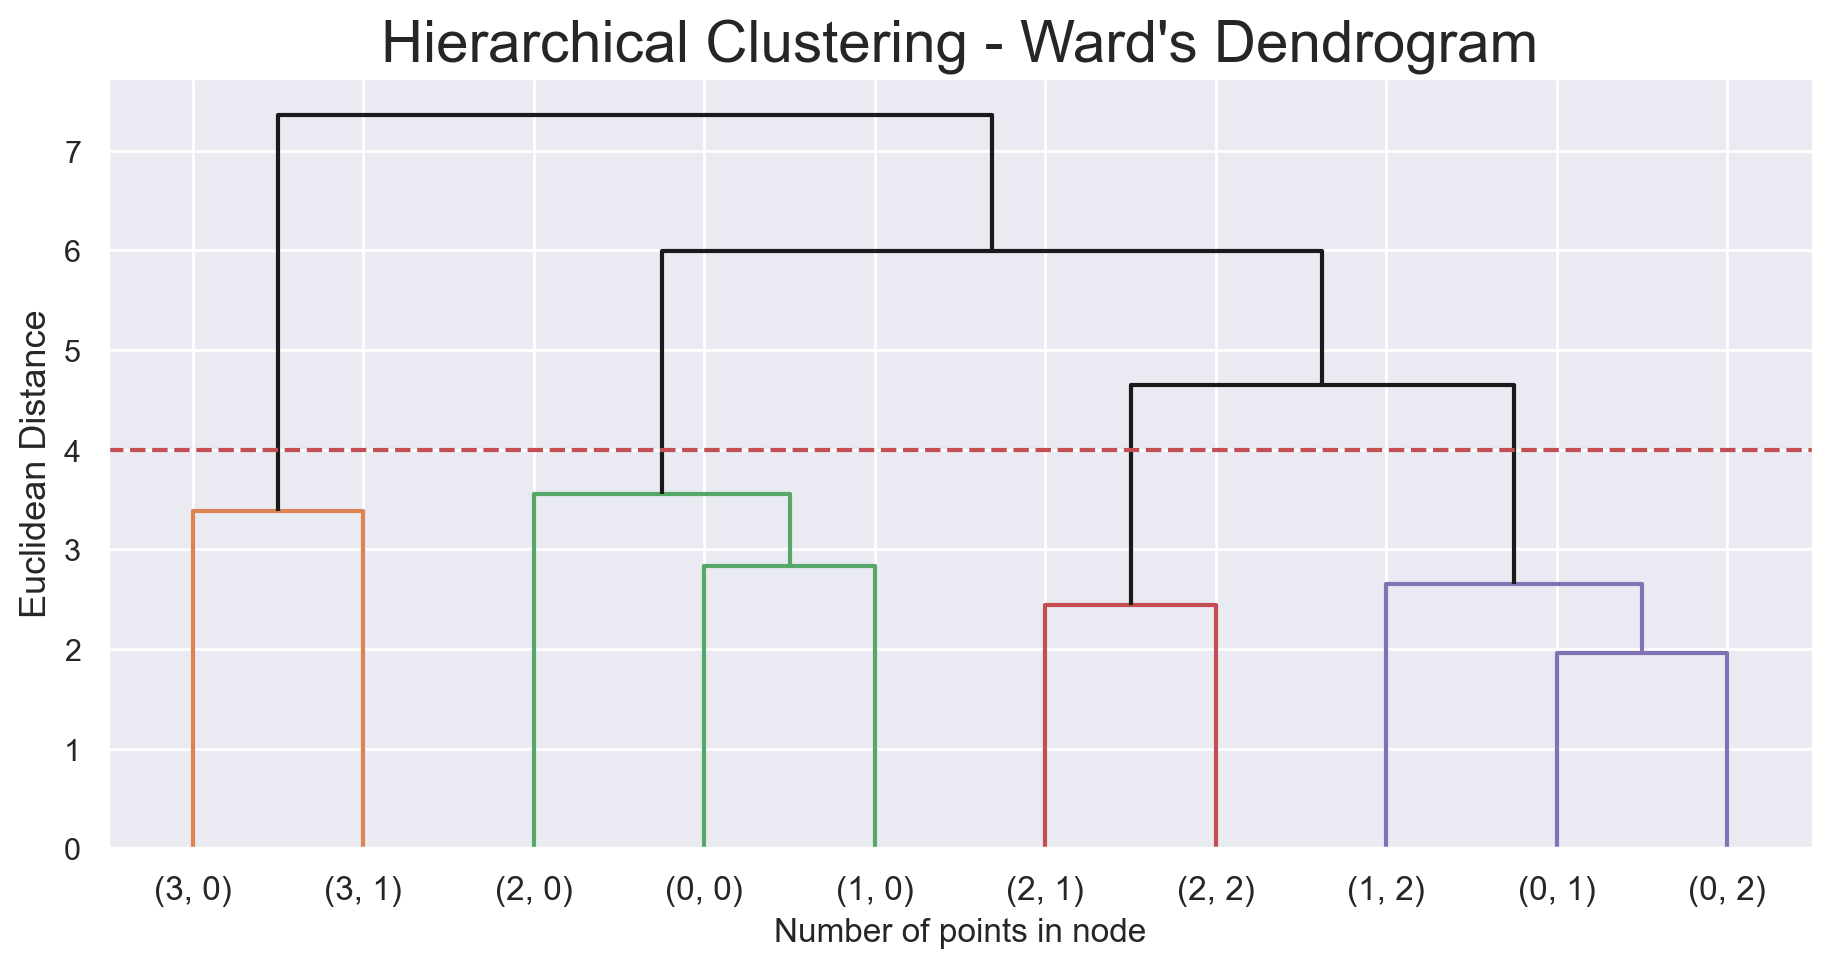

In [123]:
# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))

y_threshold = 4

dendrogram(linkage_matrix, 
           truncate_mode='level', 
           labels=df_centroids.index, p=5, 
           color_threshold=y_threshold, 
           above_threshold_color='k')

plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node')
plt.ylabel(f'Euclidean Distance', fontsize=13)
plt.show()

Let us create a clustermap to explore more the relationships between labels

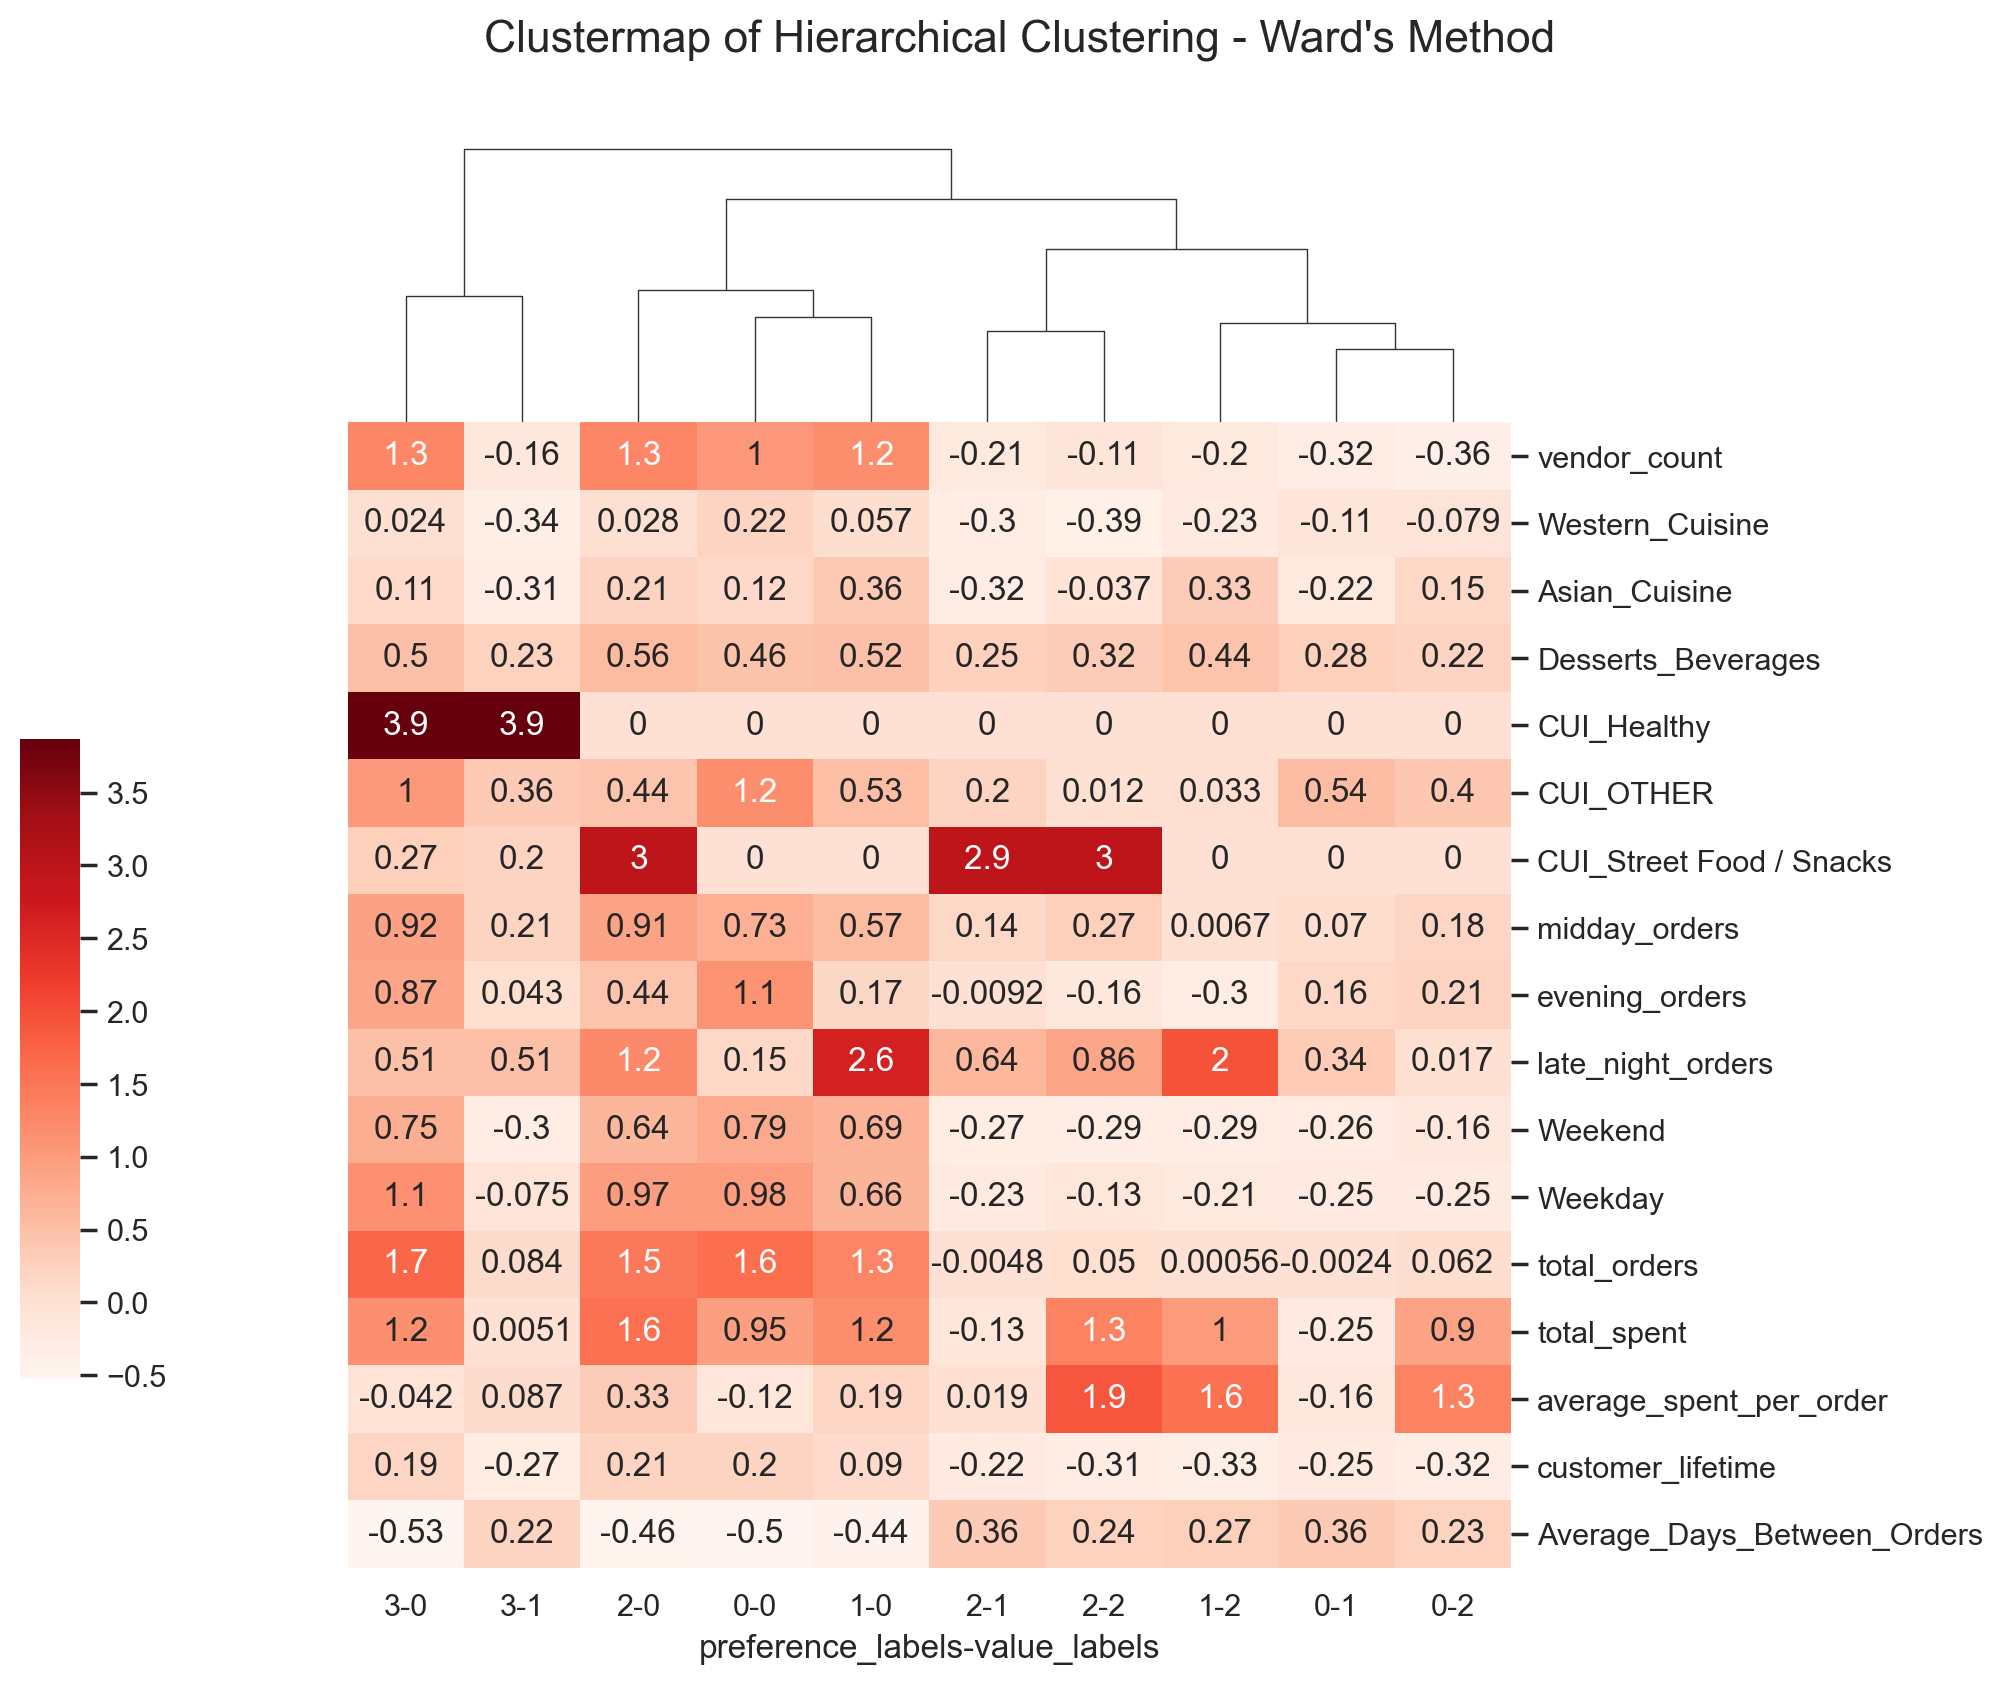

In [124]:

#First we need to trnaspose the dataframe
df_centroids_transposed = df_centroids.T

sns.set(style="whitegrid")
g = sns.clustermap(
    df_centroids_transposed,  
    method=linkage, 
    metric='euclidean', 
    figsize=(10, 8),
    cmap="Reds",
    row_cluster=False,  
    col_cluster=True,   
    annot=True,  #Showing the values in the grid
    cbar_pos=(0, .2, .03, .4)  
)

plt.suptitle(f'Clustermap of Hierarchical Clustering - {linkage.title()}\'s Method', fontsize=16, y=1.05)
plt.show()



>The clustermap highlights distinct customer segments based on preferences and behaviors:

- labels 3-0 and 3-1 seems to be the only ones with preferences in the Healthy cuisines, hence these might be merged into 1 cluster
- labels 2-0, 2-1 and 2-2 seem to be the clusters with the highest interests in the Street Food/Snacks cuisine, so they might be merged
- labels 1-0 and 1-2 have the highest values in late-night orders

In [125]:
#Re-running the Hierarchical clustering based on the correct number of clusters
hclust = AgglomerativeClustering(
    linkage='ward', 
    metric='euclidean', 
    n_clusters=4
)

hclust_labels = hclust.fit_predict(df_centroids)
df_centroids['hclust_labels'] = hclust_labels

df_centroids  # centroid's cluster labels

vendor_count  Western_Cuisine  Asian_Cuisine  \
preference_labels value_labels                                                 
0                 0                 1.047098         0.224128       0.124886   
                  1                -0.315967        -0.108722      -0.217825   
                  2                -0.364800        -0.079320       0.148454   
1                 0                 1.188967         0.056616       0.362805   
                  2                -0.204794        -0.234798       0.329400   
2                 0                 1.282269         0.027959       0.205037   
                  1                -0.207641        -0.298061      -0.318107   
                  2                -0.108081        -0.387452      -0.037351   
3                 0                 1.287587         0.024401       0.110022   
                  1                -0.155335        -0.335564      -0.307525   

                                Desserts_Beverages  CUI_Healthy  CUI_OTHER  \
preference_labels value_labels                                               
0                 0                       0.455720      0.00000   1.201824   
                  1                       0.275915      0.00000   0.544830   
                  2                       0.224939      0.00000   0.397773   
1                 0                       0.517740      0.00000   0.531032   
                  2                       0.438252      0.00000   0.032765   
2                 0                       0.559800      0.00000   0.442331   
                  1                       0.250411      0.00000   0.195990   
                  2                       0.320175      0.00000   0.012246   
3                 0                       0.503417      3.86478   1.019123   
                  1                       0.232029      3.86416   0.356926   

                                CUI_Street Food / Snacks  midday_orders  \
preference_labels value_labels                                            
0                 0                             0.000000       0.725041   
                  1                             0.000000       0.069975   
                  2                             0.000000       0.176533   
1                 0                             0.000000       0.569640   
                  2                             0.000000       0.006728   
2                 0                             2.951287       0.909170   
                  1                             2.947442       0.142488   
                  2                             2.982225       0.273401   
3                 0                             0.274604       0.919580   
                  1                             0.195006       0.207810   

                                evening_orders  late_night_orders   Weekend  \
preference_labels value_labels                                                
0                 0                   1.094085           0.150580  0.794527   
                  1                   0.156160           0.336906 -0.258736   
                  2                   0.212267           0.016800 -0.159600   
1                 0                   0.172926           2.645540  0.693662   
                  2                  -0.299972           1.957107 -0.292683   
2                 0                   0.435028           1.224250  0.639505   
                  1                  -0.009228           0.636766 -0.274086   
                  2                  -0.163636           0.864646 -0.293939   
3                 0                   0.874709           0.506993  0.752622   
                  1                   0.042538           0.511506 -0.298640   

                                 Weekday  total_orders  total_spent  \
preference_labels value_labels                                        
0                 0             0.975124      1.615036     0.947615   
                  1            -0.245362     -0.002432    -0.253482   


In [126]:
#Mapper between concatenated clusters and hierarchical clusters
cluster_mapper = df_centroids['hclust_labels'].to_dict()
cluster_mapper

{(0, 0): 0,
 (0, 1): 2,
 (0, 2): 2,
 (1, 0): 0,
 (1, 2): 2,
 (2, 0): 0,
 (2, 1): 3,
 (2, 2): 3,
 (3, 0): 1,
 (3, 1): 1}

In [127]:
df_ = food_df.copy()

# Mapping the hierarchical clusters on the centroids to the observations
df_['merged_labels'] = df_.apply(
    lambda row: cluster_mapper[
        (row['preference_labels'], row['value_labels'])
    ], axis=1
)
df_ 

customer_region  vendor_count last_promo payment_method  \
0                2000           0.0    FREEBIE           CARD   
1                4000           0.0   DELIVERY           CARD   
2                2000           0.0    FREEBIE           CARD   
3                8000          -0.5    FREEBIE           CARD   
4                4000          -0.5    NOPROMO           CARD   
...               ...           ...        ...            ...   
21167            2000          -0.5   DELIVERY           CARD   
21168            2000          -0.5    NOPROMO           CARD   
21169            4000           0.5    NOPROMO           CARD   
21170            4000          -0.5   DISCOUNT           CARD   
21171            2000          -0.5    NOPROMO           DIGI   

       Western_Cuisine  Asian_Cuisine  Desserts_Beverages  CUI_Healthy  \
0             0.103421      -0.701050             0.00000          0.0   
1            -0.622102       0.268825             0.00000          0.0   
2            -0.039866      -0.701050             0.99194          0.0   
3            -0.622102       0.314110             0.00000          0.0   
4             0.612104      -0.701050             0.00000          0.0   
...                ...            ...                 ...          ...   
21167         0.327636      -0.701050             0.00000          0.0   
21168        -0.114316      -0.222656             0.00000          0.0   
21169        -0.622102       0.613221             0.00000          0.0   
21170         0.397738       0.274381             0.00000          0.0   
21171        -0.622102      -0.138577             0.00000          0.0   

       CUI_OTHER  CUI_Street Food / Snacks  midday_orders  evening_orders  \
0       2.341739                       0.0       0.333333        0.000000   
1       2.276028                       0.0      -0.333333        0.666667   
2       1.403634                       0.0       0.333333        0.000000   
3       0.000000                       0.0       0.333333       -0.333333   
4       0.000000                       0.0       0.000000        0.000000   
...          ...                       ...            ...             ...   
21167   0.000000                       0.0      -0.333333        0.333333   
21168   0.000000                       0.0      -0.333333       -0.333333   
21169   0.000000                       0.0       1.000000       -0.333333   
21170   0.000000                       0.0       0.000000        0.666667   
21171   0.000000                       0.0       0.000000        0.000000   

       late_night_orders  Weekend  Weekday  total_orders  total_spent  \
0                    0.0      0.0     -0.5      0.000000    -0.570526   
1                    0.0      0.5     -1.0      0.000000    -0.044912   
2                    0.0      0.0     -0.5      0.000000    -0.741404   
3                    0.0      0.0     -1.0     -0.333333    -0.076842   
4                    0.0      0.0     -1.0     -0.333333     0.102105   
...                  ...      ...      ...           ...          ...   
21167                0.0     -0.5     -0.5     -0.333333    -0.561754   
21168                2.0     -0.5     -0.5     -0.333333    -0.697895   
21169                0.0      0.0      0.0      0.333333     0.955088   
21170                0.0     -0.5      0.5      0.333333     0.297544   
21171                0.0     -0.5     -0.5     -0.333333    -0.720702   

       average_spent_per_order  customer_lifetime food_diversity_category  \
0                    -0.631579           0.645161        Medium Diversity   
1                     0.078236           0.645161           Low Diversity   
2                    -0.863442           0.645161        Medium Diversity   
3                     0.607397           0.645161           Low Diversity   
4                     0.971550           0.645161           Low Diversity   
...                        ...                ...                     ..

In [128]:
df_.groupby('merged_labels').mean(numeric_only=True)[food_numerical]

vendor_count  Western_Cuisine  Asian_Cuisine  \
merged_labels                                                 
0                  1.104325         0.171414       0.163581   
1                  0.384817        -0.200813      -0.151218   
2                 -0.310714        -0.117077      -0.135974   
3                 -0.155573        -0.344811      -0.171277   

               Desserts_Beverages  CUI_Healthy  CUI_OTHER  \
merged_labels                                               
0                        0.480970     0.000000   0.995482   
1                        0.333622     3.864392   0.604817   
2                        0.285462     0.000000   0.486301   
3                        0.286896     0.000000   0.099896   

               CUI_Street Food / Snacks  midday_orders  evening_orders  \
merged_labels                                                            
0                              0.537937       0.742871        0.880703   
1                              0.224803       0.474258        0.354058   
2                              0.000000       0.074257        0.121293   
3                              2.965633       0.210953       -0.089981   

               late_night_orders   Weekend   Weekday  total_orders  \
merged_labels                                                        
0                       0.598859  0.756060  0.941896      1.557668   
1                       0.509817  0.094895  0.380563      0.692190   
2                       0.449605 -0.252566 -0.242118      0.003790   
3                       0.755943 -0.284469 -0.179873      0.023772   

               total_spent  average_spent_per_order  customer_lifetime  \
merged_labels                                                            
0                 1.089779                -0.008265           0.193932   
1                 0.440321                 0.038970          -0.099814   
2                -0.035524                 0.133621          -0.265858   
3                 0.638825                 1.005380          -0.268323   

               Average_Days_Between_Orders  
merged_labels                               
0                                -0.487709  
1                                -0.062901  
2                                 0.339720  
3                                 0.300393

In [129]:
# Getting size of each final cluster
df_counts = df_.groupby('merged_labels')\
    .size()\
    .to_frame()

df_counts

0
merged_labels       
0               4208
1               1528
2              13543
3               1893

In [130]:
#The merged label clusters
df_counts = df_counts\
    .rename({v:k for k, v in cluster_mapper.items()})\
    .reset_index()

df_counts

merged_labels      0
0        (2, 0)   4208
1        (3, 1)   1528
2        (1, 2)  13543
3        (2, 2)   1893

In [131]:
#Getting the preference and value labels for each merged cluster
df_counts['preference_labels'] = df_counts['merged_labels'].apply(lambda x: x[0])
df_counts['value_labels'] = df_counts['merged_labels'].apply(lambda x: x[1])

df_counts

merged_labels      0  preference_labels  value_labels
0        (2, 0)   4208                  2             0
1        (3, 1)   1528                  3             1
2        (1, 2)  13543                  1             2
3        (2, 2)   1893                  2             2

In [132]:
#Pivoting the table to get the final clusters
df_counts.pivot(values=0, index='preference_labels', columns='value_labels')

value_labels            0       1        2
preference_labels                         
1                     NaN     NaN  13543.0
2                  4208.0     NaN   1893.0
3                     NaN  1528.0      NaN

In [133]:
# Setting df to have the final preference_labels and value_labels
food_df = df_.copy()

In [134]:
#Getting the final clusters
def cluster_profiles(food_df, label_columns, figsize, 
                     cmap="tab10",
                     compare_titles=None):
    """
    Pass food_df with labels columns of one or multiple clustering labels. 
    Then specify this label columns to perform the cluster profile according to them.
    """
    
    if compare_titles == None:
        compare_titles = [""]*len(label_columns)
        
    fig, axes = plt.subplots(nrows=len(label_columns), 
                             ncols=2, 
                             figsize=figsize, 
                             constrained_layout=True,
                             squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compare_titles):
        # Filtering food_df
        drop_cols = [i for i in label_columns if i!=label]
        food_dfax = food_df.drop(drop_cols, axis=1)
        
        # Getting the cluster centroids and counts
        centroids = food_dfax.groupby(by=label, as_index=False).mean()
        counts = food_dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
        # Setting Data
        pd.plotting.parallel_coordinates(centroids, 
                                            label, 
                                            color = custom_palette,
                                            ax=ax[0])

        sns.barplot(x=label, 
                    hue=label,
                    y="counts", 
                    data=counts, 
                    ax=ax[1], 
                    palette=custom_palette,
                    legend=False
                    )

        #Setting Layout
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        ax[0].annotate(text=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), 
                              rotation=40,
                              ha='right'
                              )
        
        ax[0].legend(handles, cluster_labels,
                     loc='center left', bbox_to_anchor=(1, 0.5), title=label
                     ) # Adaptable to number of clusters
        
        ax[1].set_xticks([i for i in range(len(handles))])
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)
    
    plt.suptitle("Cluster Simple Profiling", fontsize=23)
    plt.show()

Getting the means for the clusters, comparing by the **Preferences** and the **Customer Value** and then the **Merged Clusters**

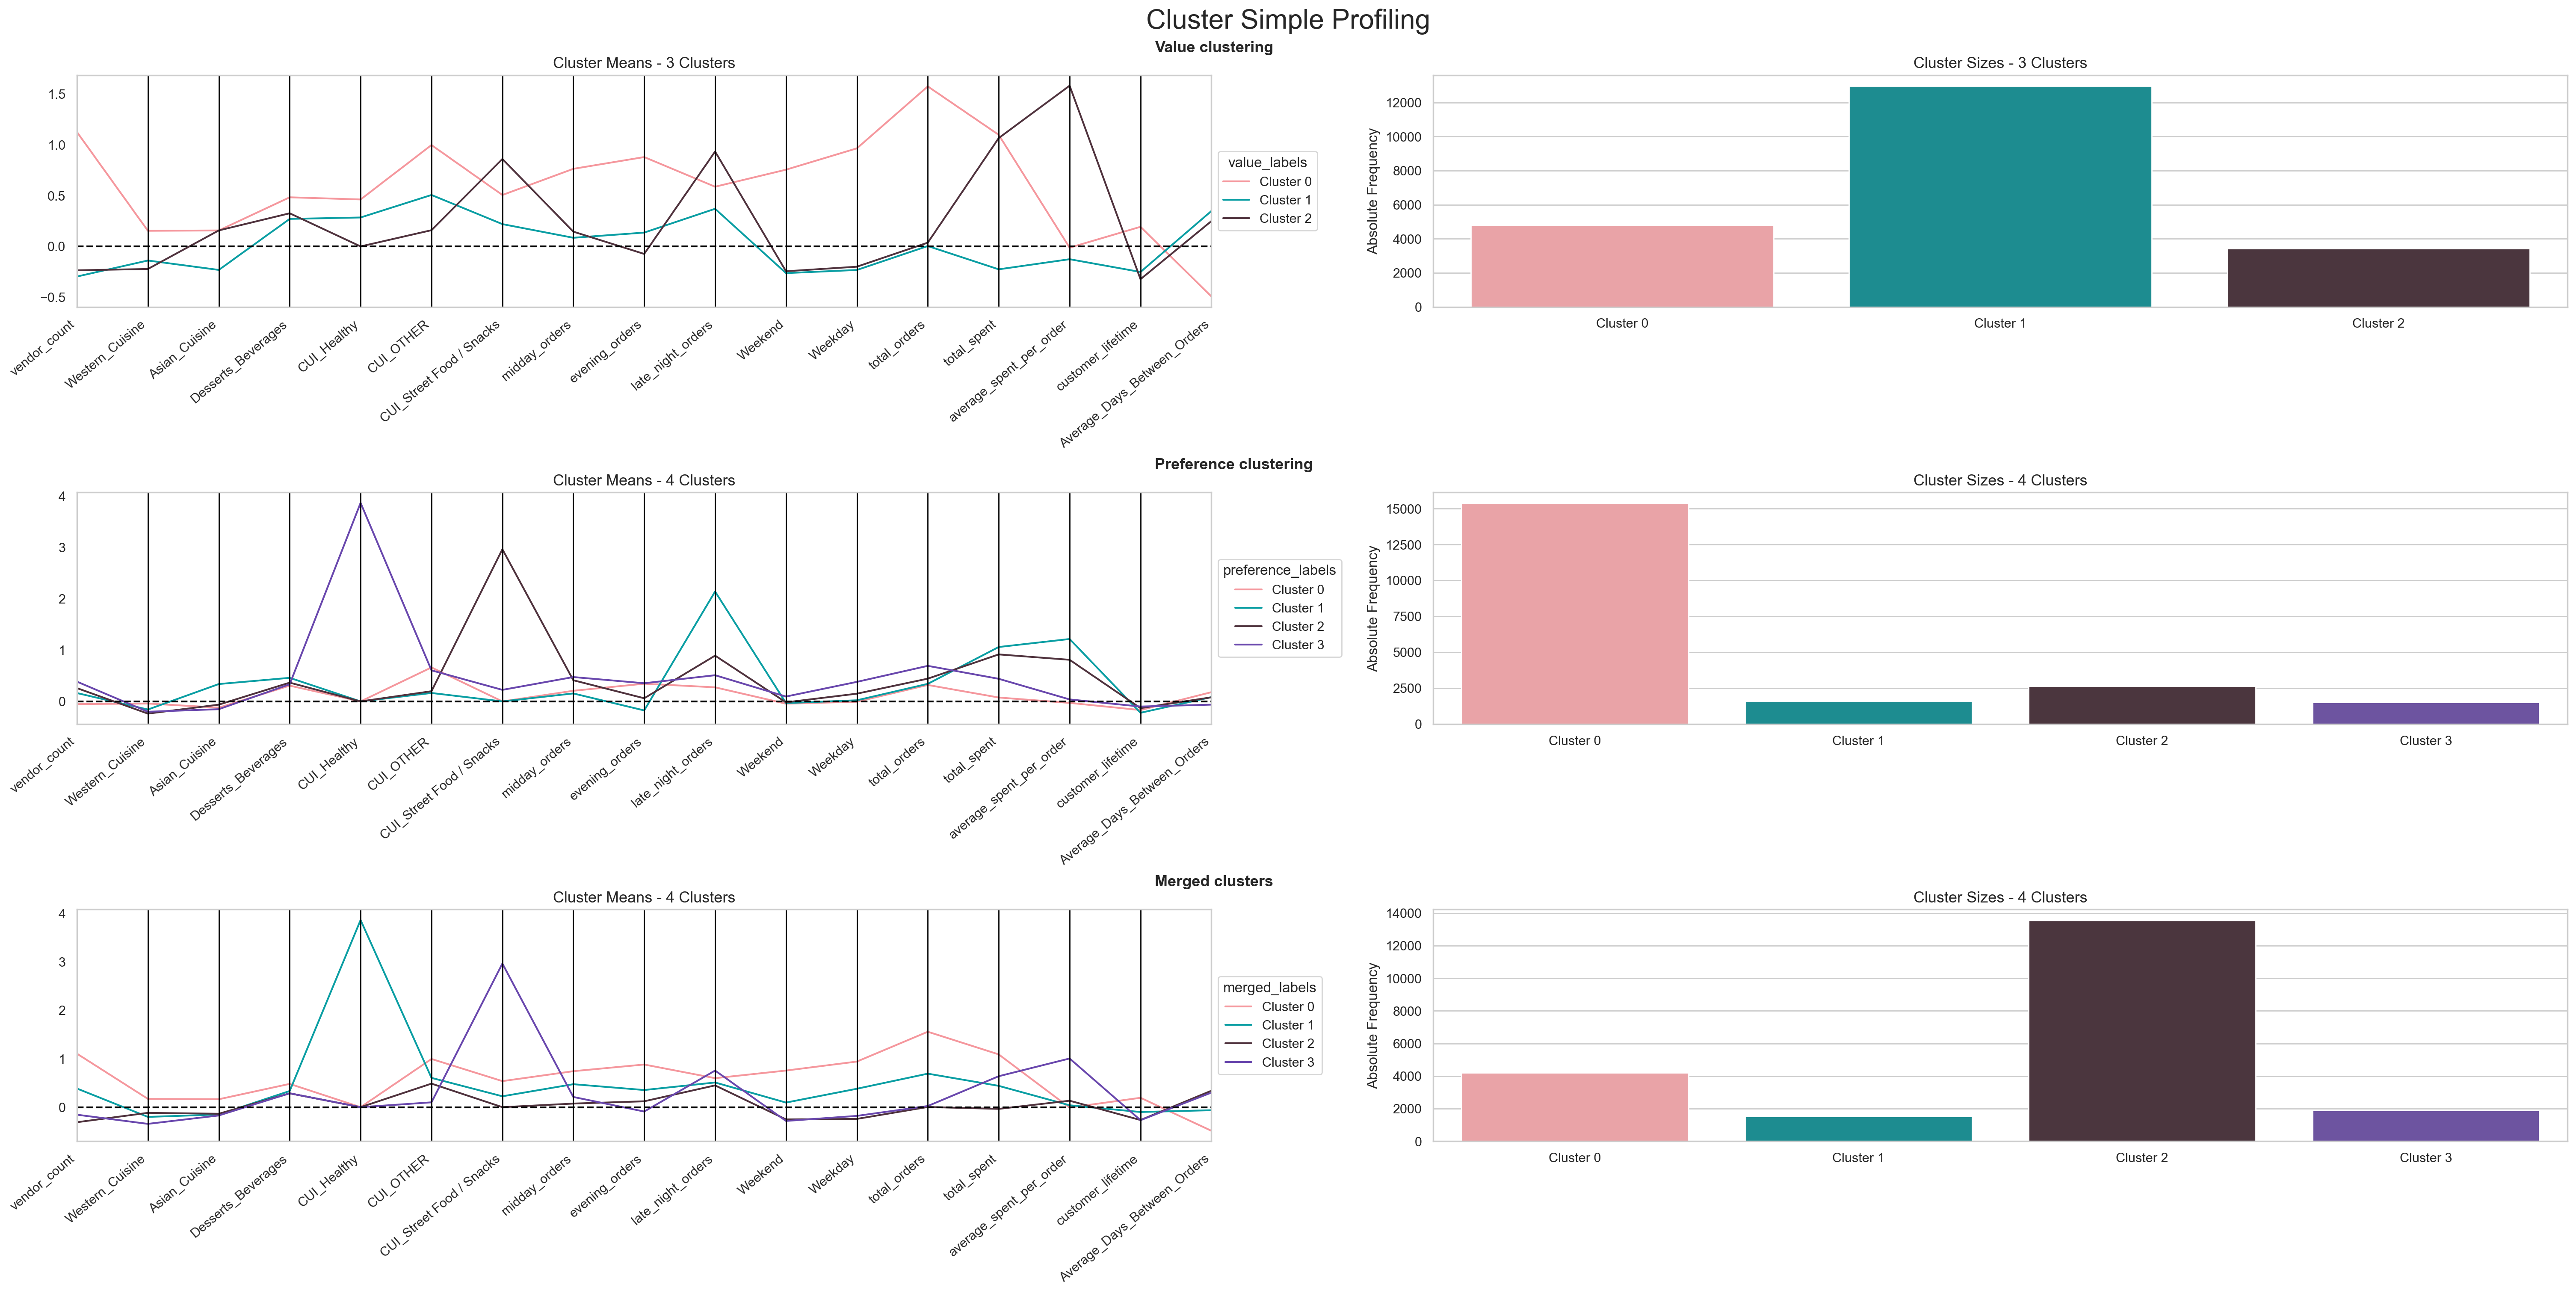

In [135]:
# Profilling each cluster (customer value, preference, merged)
cluster_profiles(
    food_df= food_df[food_numerical + ['value_labels', 'preference_labels', 'merged_labels']], 
    label_columns = ['value_labels', 'preference_labels', 'merged_labels'], 
    figsize = (30, 15), 
    compare_titles = ["Value clustering", "Preference clustering", "Merged clusters"]
)

Let us better see the exact values per features for each cluster. This will extend the information given in the visual above

In [136]:
df_.groupby('merged_labels').mean(numeric_only=True)[food_numerical]

vendor_count  Western_Cuisine  Asian_Cuisine  \
merged_labels                                                 
0                  1.104325         0.171414       0.163581   
1                  0.384817        -0.200813      -0.151218   
2                 -0.310714        -0.117077      -0.135974   
3                 -0.155573        -0.344811      -0.171277   

               Desserts_Beverages  CUI_Healthy  CUI_OTHER  \
merged_labels                                               
0                        0.480970     0.000000   0.995482   
1                        0.333622     3.864392   0.604817   
2                        0.285462     0.000000   0.486301   
3                        0.286896     0.000000   0.099896   

               CUI_Street Food / Snacks  midday_orders  evening_orders  \
merged_labels                                                            
0                              0.537937       0.742871        0.880703   
1                              0.224803       0.474258        0.354058   
2                              0.000000       0.074257        0.121293   
3                              2.965633       0.210953       -0.089981   

               late_night_orders   Weekend   Weekday  total_orders  \
merged_labels                                                        
0                       0.598859  0.756060  0.941896      1.557668   
1                       0.509817  0.094895  0.380563      0.692190   
2                       0.449605 -0.252566 -0.242118      0.003790   
3                       0.755943 -0.284469 -0.179873      0.023772   

               total_spent  average_spent_per_order  customer_lifetime  \
merged_labels                                                            
0                 1.089779                -0.008265           0.193932   
1                 0.440321                 0.038970          -0.099814   
2                -0.035524                 0.133621          -0.265858   
3                 0.638825                 1.005380          -0.268323   

               Average_Days_Between_Orders  
merged_labels                               
0                                -0.487709  
1                                -0.062901  
2                                 0.339720  
3                                 0.300393

>After merging, we ended up with 4 clusters:


- `Cluster 0`: These are customers that spent the most by **unique vendors**, they also spent the most in **Western_Cuisine and Asian Cuisine**. **These customers did not buy from CUI_Healthy**, but they bought the most on Desserts_Beverages (Their highest average in cuisine preferences). They mostly buy during the evening hours, but it seems they also buy during the midday and late night hours. The customers from this cluster have the highest total orders and total spent, but the lowest avergae spent per order. Cluster 0 seems to have the highest customer lifetime but the lowest average day between orders.

- `Cluster 1`: These are the customers that are Niched into the **CUI_Healthy**, as they are the ONLY ones that buy from this cuisine. These customers also buy from unique vendors, **but they buy less from Asian and Western cuisines**. The time of the day distribution seems pretty even for this cluster, having late night hours as slightly more predominant. **These customers are the second who spend and order the most**, but they have the second lowest avergae spent per order. Their customer lifetime and avergae days between orders is relatively lower. 

- `Cluster 2`: These are the customers that spend less on unique vendors, **they don't spend nothing on CUI_Healhty nor CUI_Street Food/Snacks**, they MOSTLY make orders during the **late night hours** both during the weekday and weeked, they have the lowest customer lifetime, but a high average days between orders. These are also the customers that ordered the least and spent the lowest, overall.

- `Cluster 3`: These are the customer that **spent the most on CUI_Street Food/Snacks** and they did not spend nothing on CUI_Healthy. They spent the **least on Western and Asian Cuisine**, having the vast majority of their orders being done during the **late night hours**, they buy mostly during the weekday and have the second highest total spent. On average, they are the ones that spend the most per order, but they have a low customer lifetime, but a high average days bewteen orders.

>These results gave us a good insight of who are the customers. We may use this for defining the marketing strategies.

# Cluster visualization using t-SNE

In [137]:
two_dim = TSNE(random_state=1).fit_transform(food_df[food_numerical])


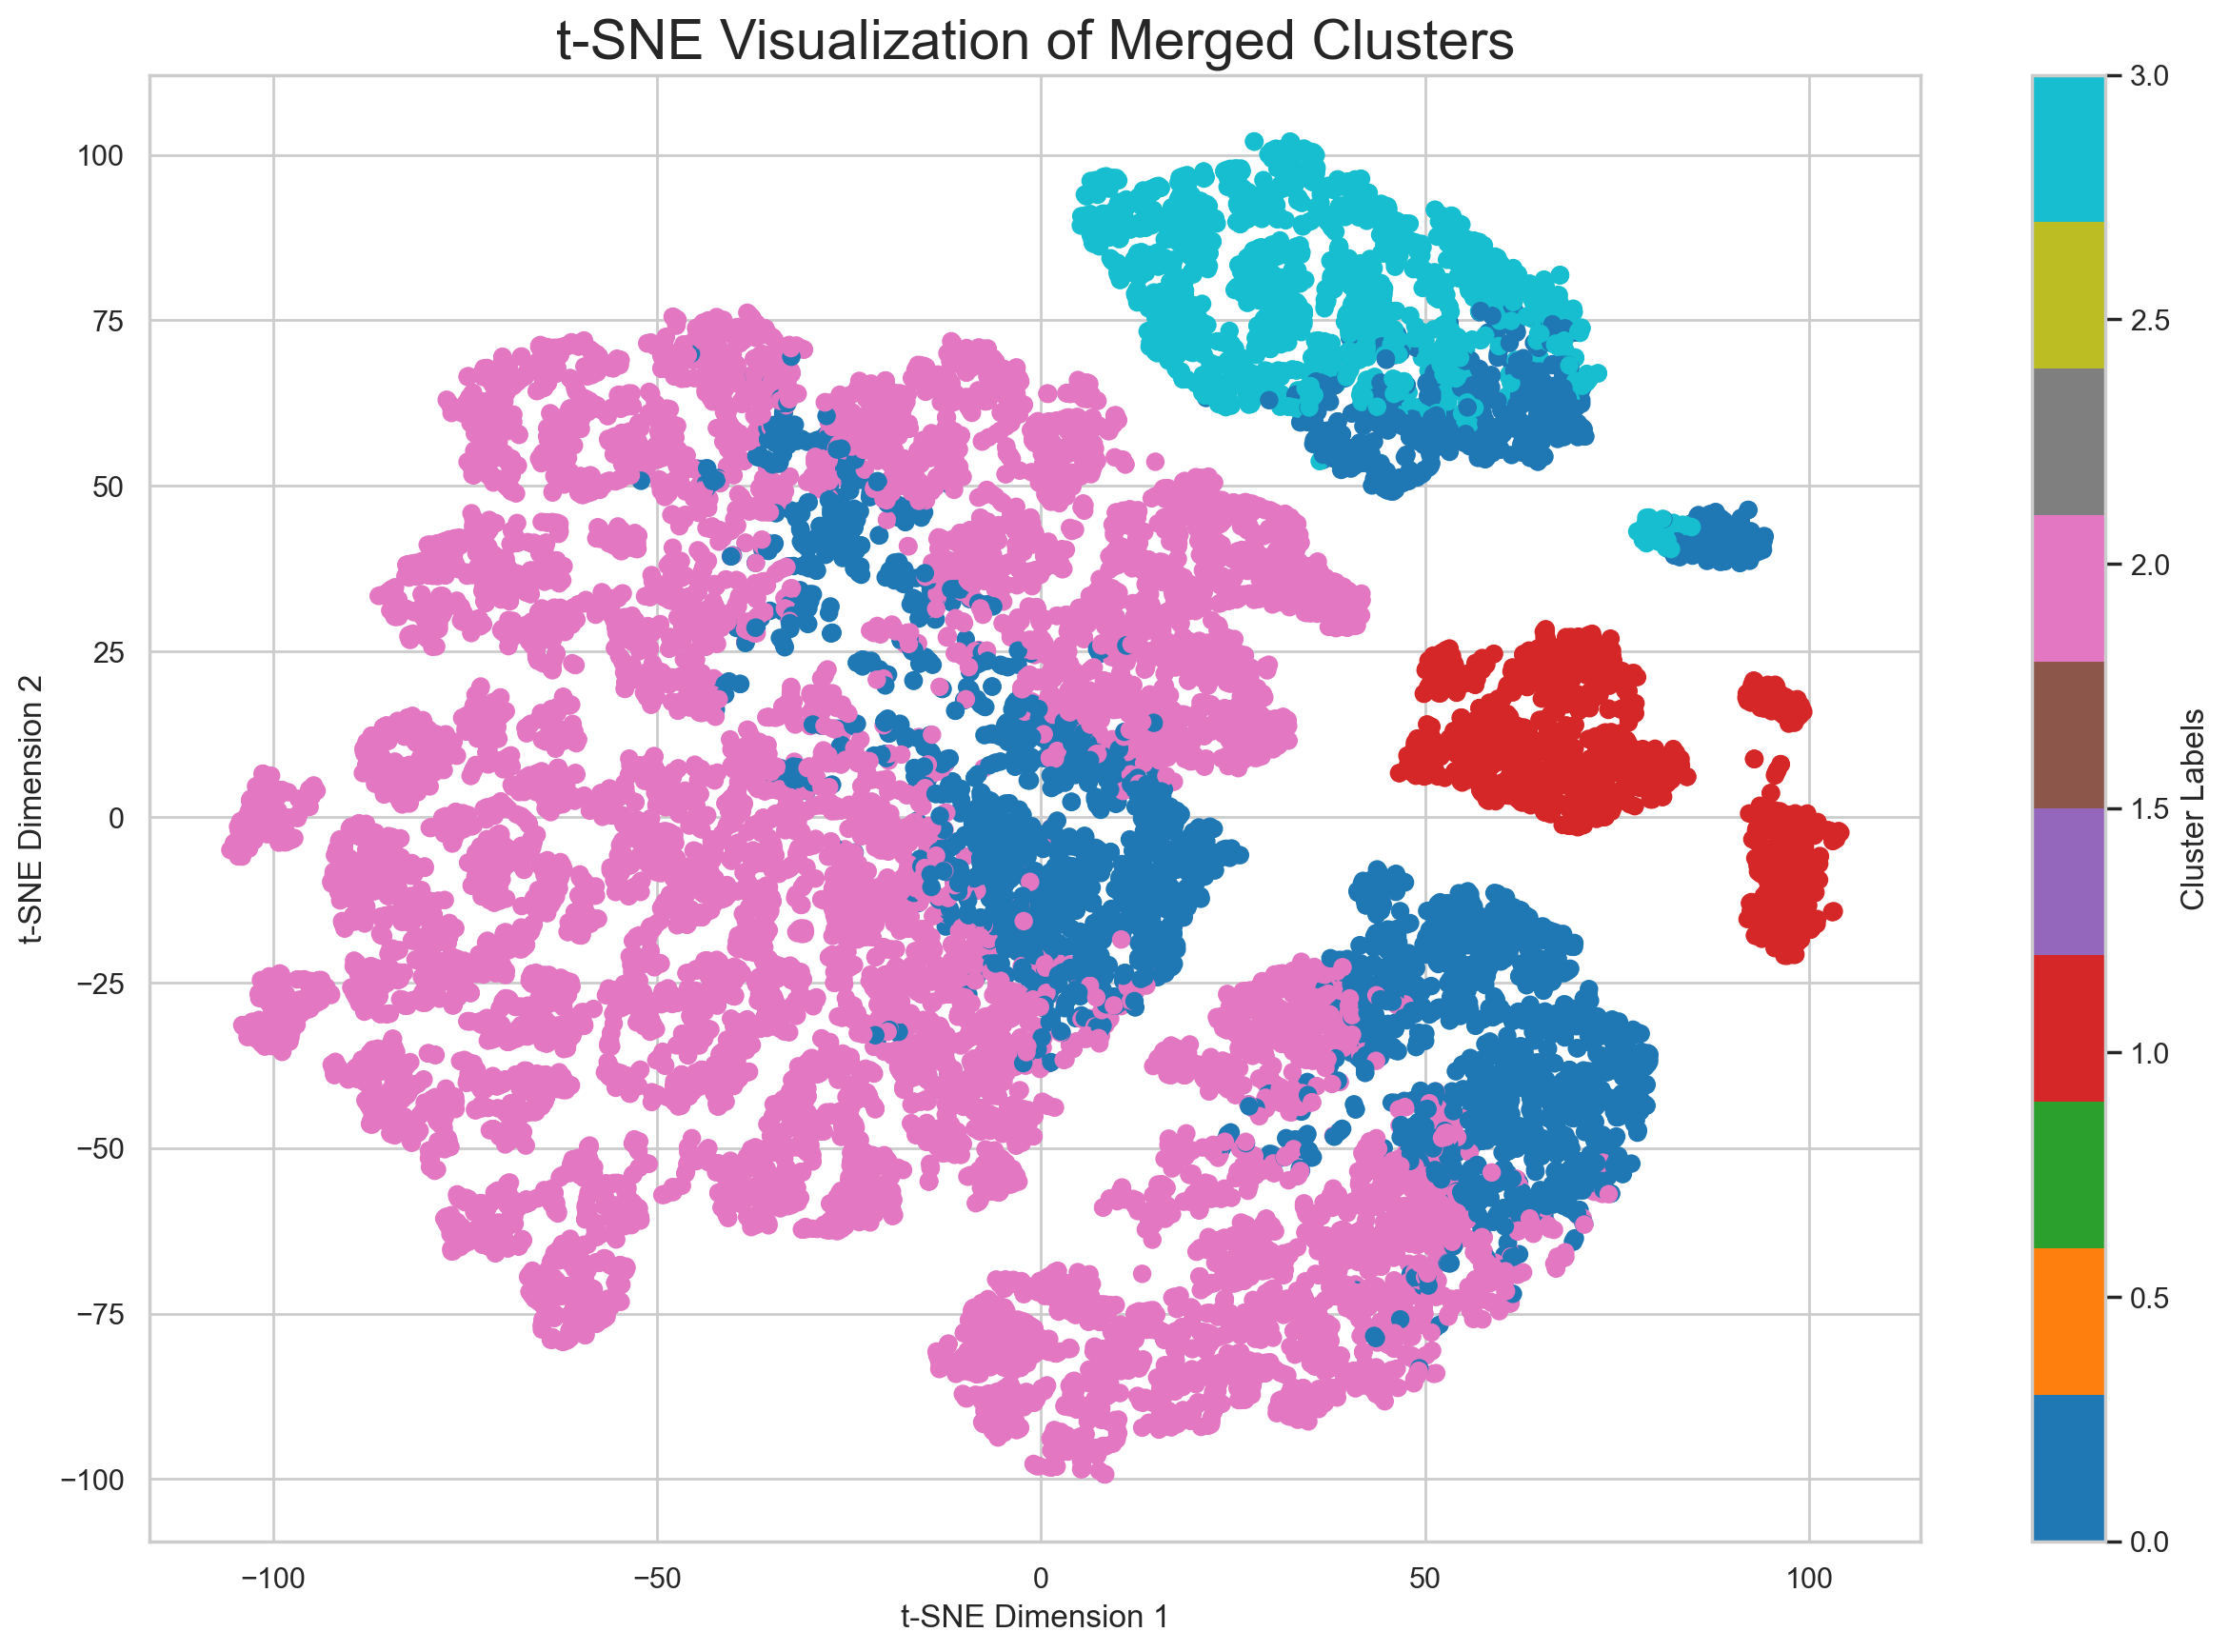

In [138]:
# t-SNE visualization
plt.figure(figsize=(15, 10))
scatter = plt.scatter(two_dim[:, 0], two_dim[:, 1], c=food_df['merged_labels'], cmap='tab10')

plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("t-SNE Visualization of Merged Clusters", fontsize=21)

plt.colorbar(scatter, label="Cluster Labels")
plt.grid(True)

plt.show()

>We can see that some clusters overlap with each other but they can still be well distinguished.

#### Scores

In [139]:
def get_ss_score(df):
    """Computes the sum of squares for all variables given a dataset
    """
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

In [140]:
#Silhouette Score for Hierarchical Clustering
hc_silhouette = silhouette_score(df_centroids[food_numerical], df_centroids['hclust_labels'])
print(f"Hierarchical Clustering Silhouette Score: \033[1;35m{hc_silhouette:.3f}\033[1;0m")

Hierarchical Clustering Silhouette Score: 0.235


In [141]:

#Calinski-Harabasz Index for Hierarchical Clustering
hc_chi = calinski_harabasz_score(df_centroids[food_numerical], df_centroids['hclust_labels'])
print(f"Hierarchical Clustering Calinski-Harabasz Index: \033[1;35m{hc_chi:.3f}\033[1;0m")

Hierarchical Clustering Calinski-Harabasz Index: 4.558


In [142]:
#SST (Total Sum of Squares)
sst_hc = get_ss_score(df_centroids[food_numerical])  

#SSW (Sum of Squares Within)
ssw_labels_hc = df_centroids.groupby(by='hclust_labels').apply(get_ss_score)
ssb_hc = sst_hc - np.sum(ssw_labels_hc)

#R² Score
r2_hc = ssb_hc / sst_hc
print(f"Hierarchical Clustering R²: \033[1;35m{r2_hc:.4f}\033[1;0m")


Hierarchical Clustering R²: 0.6950


# Feature Importance

In this section we are going to evaluate the scores for each of the feature using the R2 and Deciosn Tree. This was done to understand whihc features influence more the cluster formations.

### Using the R2
What proportion of each variables total SS is explained between clusters?

In [143]:
def get_ss_variables(df):
    """Get the SS for each variable
    """
    ss_vars = df.var() * (df.count() - 1)
    return ss_vars

def r2_variables(df, labels):
    """Get the R² for each variable
    """
    sst_vars = get_ss_variables(df)
    ssw_vars = np.sum(df.groupby(labels).apply(get_ss_variables))
    return 1 - ssw_vars/sst_vars

In [144]:
#Getting the R2 for each variable
r2_variables(food_df[food_numerical + ['merged_labels']], 'merged_labels').drop('merged_labels').round(3).sort_values(ascending=True)

late_night_orders              0.010
Desserts_Beverages             0.020
CUI_OTHER                      0.060
Asian_Cuisine                  0.067
customer_lifetime              0.077
Western_Cuisine                0.081
average_spent_per_order        0.100
Average_Days_Between_Orders    0.227
evening_orders                 0.236
midday_orders                  0.244
total_spent                    0.263
Weekend                        0.285
Weekday                        0.341
vendor_count                   0.515
total_orders                   0.601
CUI_Street Food / Snacks       0.697
CUI_Healthy                    1.000
dtype: float64

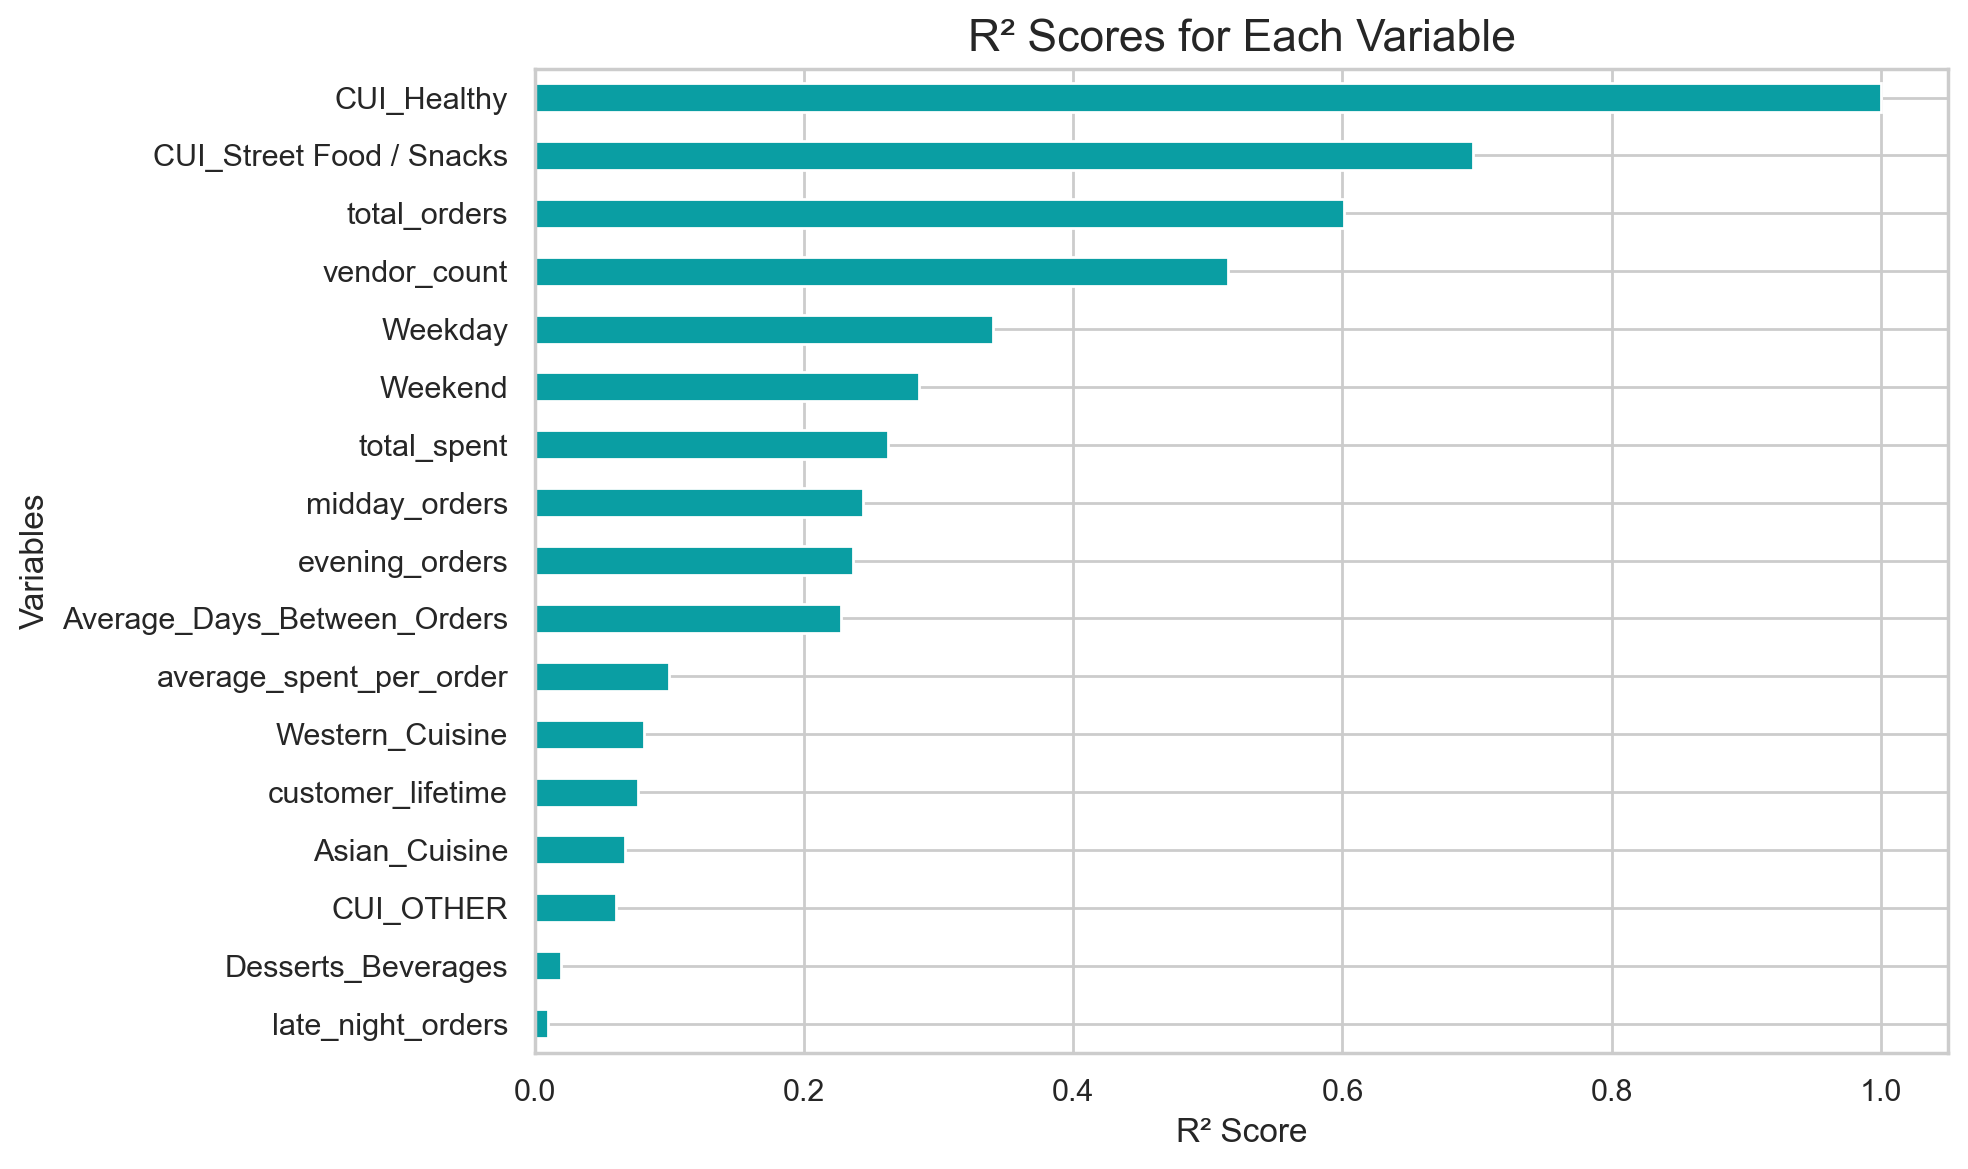

In [145]:

#Calculate R2 values for each variable (excluding 'merged_labels')
r2_values = r2_variables(food_df[food_numerical + ['merged_labels']], 'merged_labels').drop('merged_labels')

r2_values_sorted = r2_values.sort_values(ascending=True)
plt.figure(figsize=(10, 6))
r2_values_sorted.plot(kind='barh', color=colors['BL'])

plt.title('R² Scores for Each Variable', fontsize=16)
plt.xlabel('R² Score', fontsize=12)
plt.ylabel('Variables', fontsize=12)
plt.tight_layout()

plt.show()



- `CUI_Healthy` and `CUI_Street Food/Snacks`, are the **Customer preference** features what present the highest R2 score, with CUI_Healthy having an almot perfect value (0.999)
- Out of the **customer values** features, the `total orders`and the `vendor count` seem to have the highest R2 scores
- The features, deemed as less important are the `late_night` orders for the **customer preferences**, and the `customer lifetime` for the **customer value**

### Using a Decision Tree
We get the normalized total reduction of the criterion (gini or entropy) brought by that feature (also known as Gini importance).

In [146]:
#Preparing the data
X = food_df[food_numerical]
y = food_df.merged_labels

#Splitting the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#Fitting the decision tree
dt = DecisionTreeClassifier(random_state=42, max_depth=3)
dt.fit(X_train, y_train)
print("It is estimated that in average, we are able to predict \033[1;35m{0:.2f}%\033[1;0m of the customers correctly".format(dt.score(X_test, y_test)*100))

It is estimated that in average, we are able to predict 95.42% of the customers correctly


In [147]:
# Assessing feature importance
feature_importance=pd.Series(dt.feature_importances_, index=X_train.columns).sort_values(ascending=False)

feature_importance

total_orders                   0.404844
CUI_Street Food / Snacks       0.305214
CUI_Healthy                    0.273668
vendor_count                   0.016274
Weekend                        0.000000
customer_lifetime              0.000000
average_spent_per_order        0.000000
total_spent                    0.000000
Weekday                        0.000000
evening_orders                 0.000000
late_night_orders              0.000000
Western_Cuisine                0.000000
midday_orders                  0.000000
CUI_OTHER                      0.000000
Desserts_Beverages             0.000000
Asian_Cuisine                  0.000000
Average_Days_Between_Orders    0.000000
dtype: float64

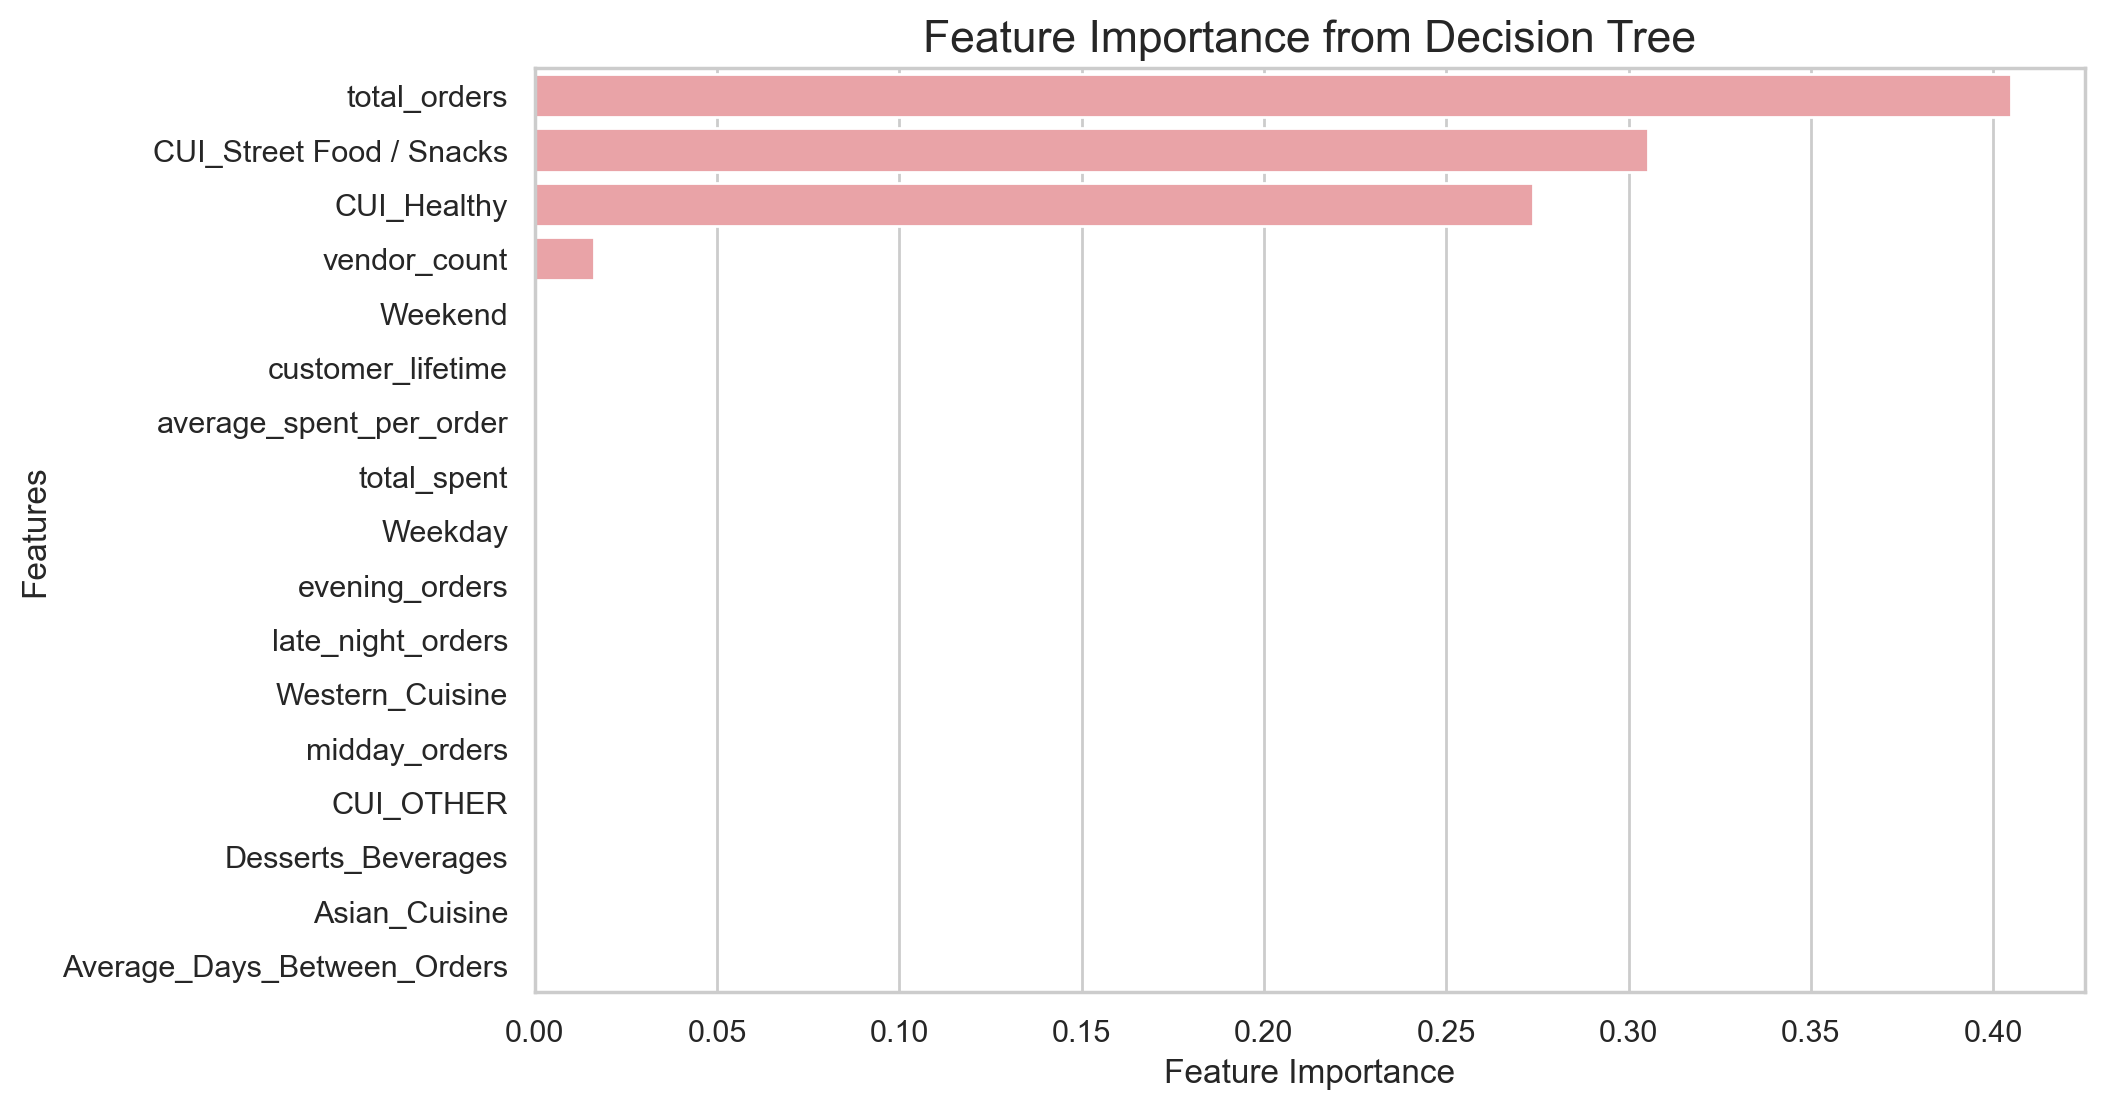

In [148]:
# Plotting the feature importances into a barplot
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance.values, y=feature_importance.index, palette=[colors["R"]])
plt.title("Feature Importance from Decision Tree", fontsize=16)
plt.xlabel("Feature Importance", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.show()

>The Decison tree classifier discarded all the features, except for the following:
- `Total orders`, which had the higherst score for feature importance.
- `CUI_Healthy` and `CUI_Street Food/Snacks` were the only **Customer preference** features that were selected.
- `Vendor count` was also selected but wiht a very low score.

# Categorical Features

In [149]:
categorical_features = 'customer_region','last_promo', 'payment_method','chain_category', 'food_diversity_category'

    Customer Region

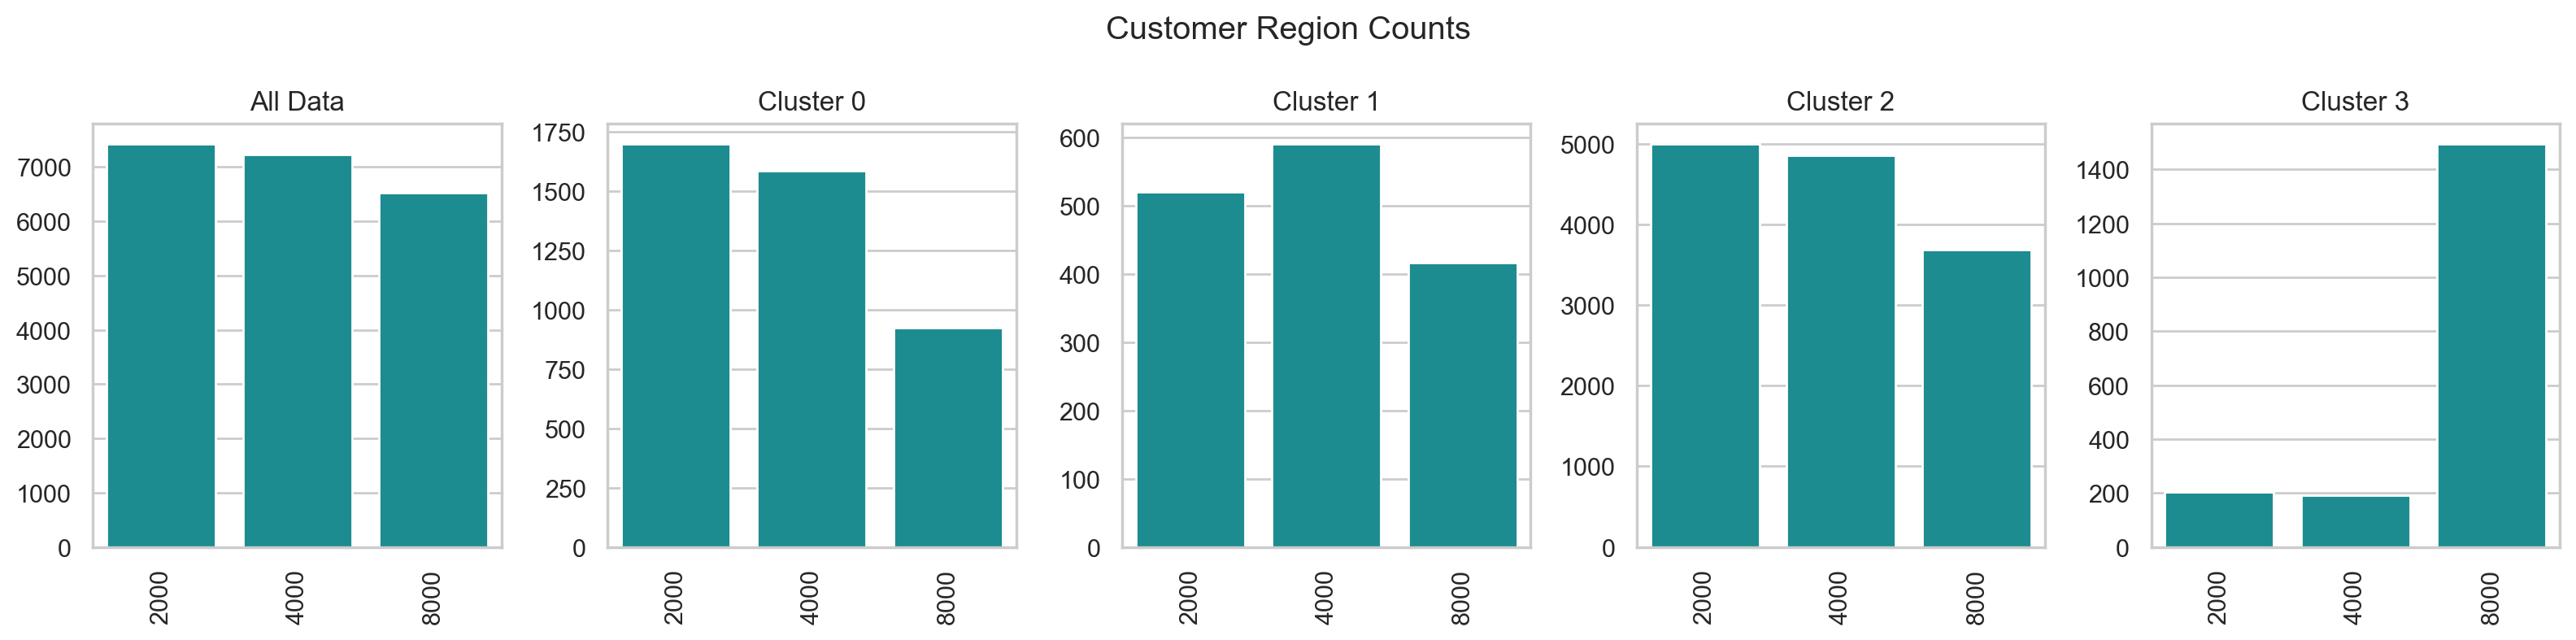

In [150]:
fig, axes = plt.subplots(1, 
                         food_df['merged_labels'].nunique() + 1,  # Add an extra ax for population countplot
                         figsize=(16, 4),
                         tight_layout=True,
                        )

for i in range(len(axes.flatten())): 
    ax = axes[i]
    if i == 0:
        sns.countplot(data=food_df, 
                      x='customer_region', 
                      order=food_df['customer_region'].value_counts().index,
                      ax=ax,
                      palette=[colors["BL"]])  
        ax.set_title("All Data")
        
    else:    
        sns.countplot(data=food_df[food_df['merged_labels'] == i-1], 
                      x='customer_region', 
                      order=food_df['customer_region'].value_counts().index,
                      ax=ax,
                      palette=[colors["BL"]])  
        ax.set_title(f"Cluster {i-1}")
    
    ax.tick_params(axis="x", labelrotation=90)
    ax.set_xlabel("")
    ax.set_ylabel("")

plt.suptitle("Customer Region Counts")
plt.show()

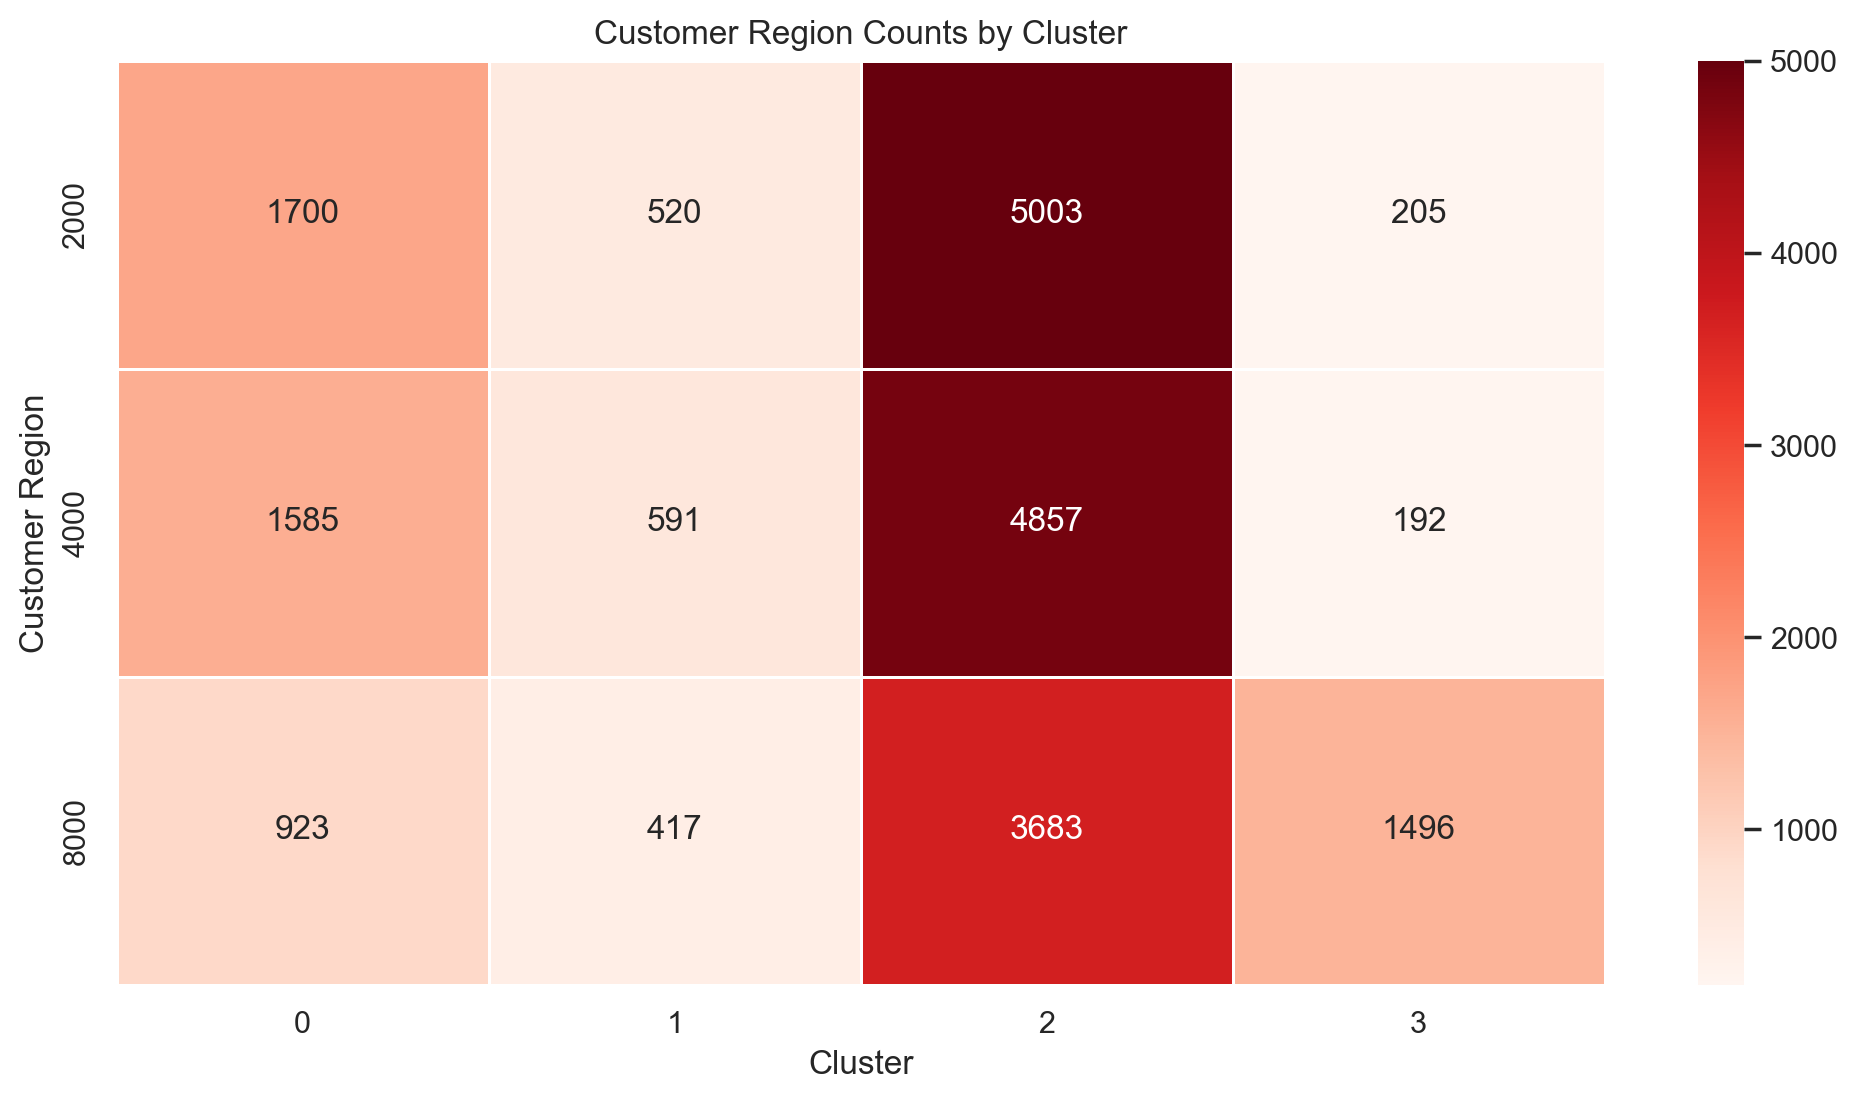

In [151]:
region_counts = pd.crosstab(food_df['customer_region'], food_df['merged_labels'])
plt.figure(figsize=(12, 6))
sns.heatmap(region_counts, annot=True, cmap='Reds', fmt="d", linewidths=0.5)

plt.title("Customer Region Counts by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Customer Region")

plt.show()

We can observe the following:
- `Cluster 0`: is the cluster with the least customers from the region 8000, in comparison to the other regions
- `Cluster 1`: seems that the customers from this cluster are well distributed among the regions.
- `Cluster 2`: customers are well distributed among regions
- `Cluster 3`: these customers are mostly from the region 8000, as only around 400 are from region 2000 and 4000

    Chain Category

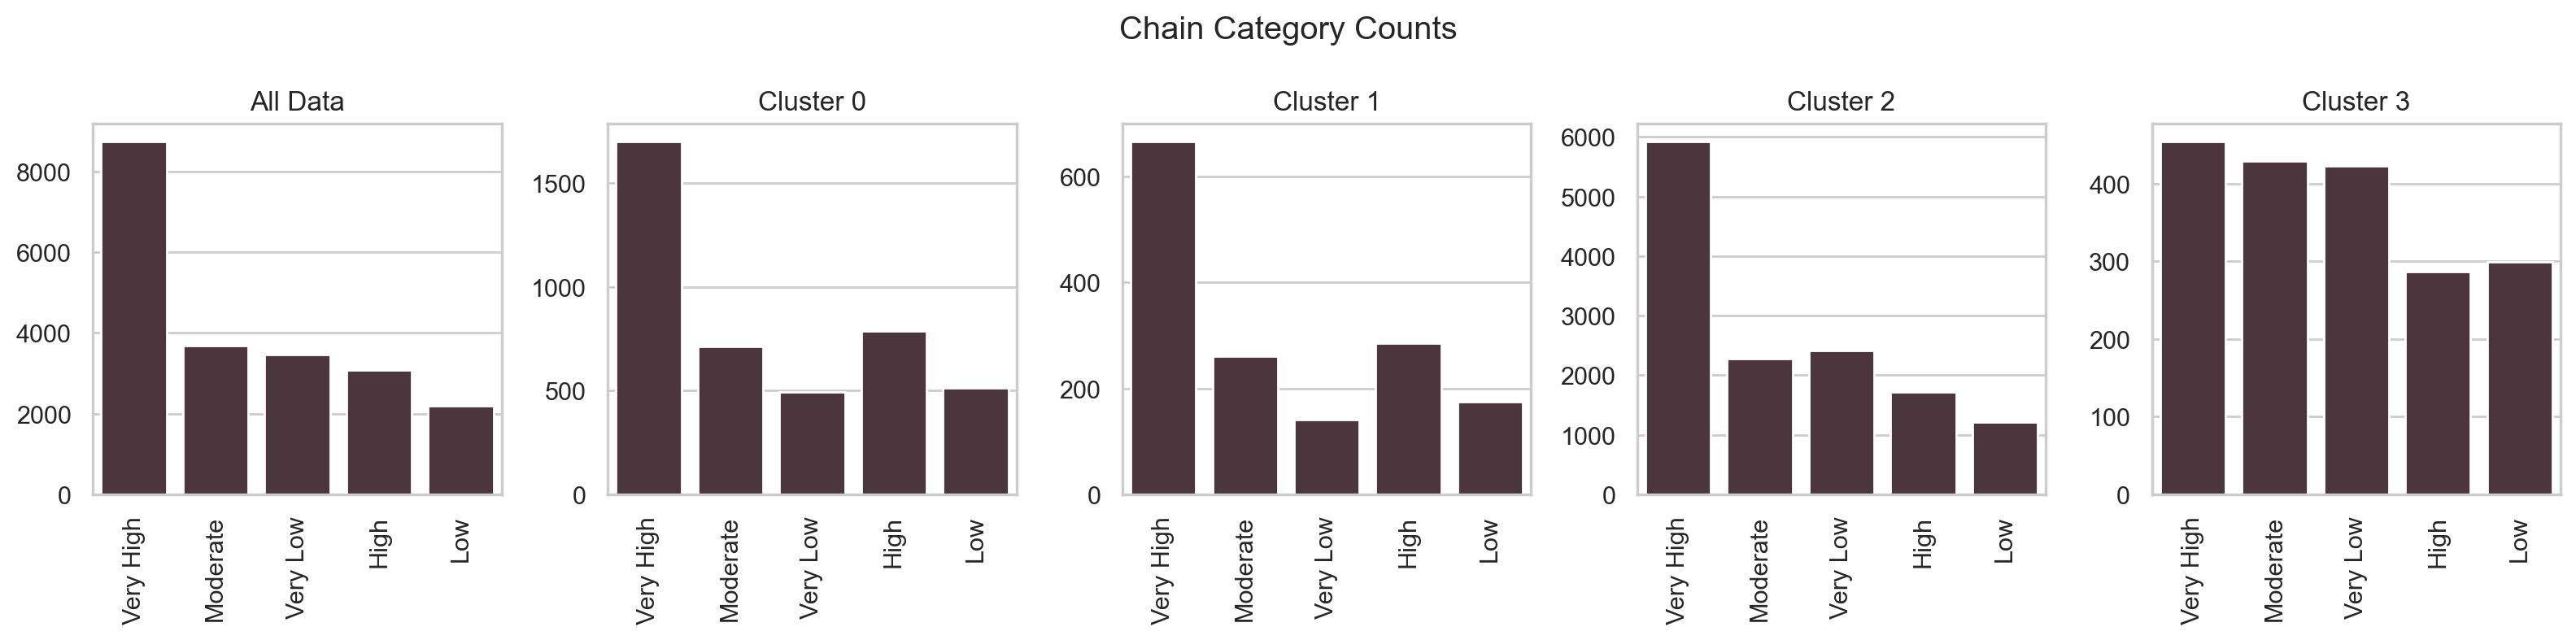

In [152]:
fig, axes = plt.subplots(1, 
                         food_df['merged_labels'].nunique() + 1, # Add an extra ax for population countplot
                         figsize=(16, 4),
                         tight_layout=True,
                        )

for i in range(len(axes.flatten())): 
    ax = axes[i]
    if i == 0:
        sns.countplot(data=food_df, 
                      x='chain_category', 
                      order=food_df['chain_category'].value_counts().index,
                      ax=ax,
                    palette=[colors["BR"]])  

        ax.set_title("All Data")
        
    else:    
        sns.countplot(data=food_df[food_df['merged_labels'] == i-1], 
                      x='chain_category', 
                      order=food_df['chain_category'].value_counts().index,
                      ax=ax,
                    palette=[colors["BR"]])  

        ax.set_title(f"Cluster {i-1}")
    
    ax.tick_params(axis="x", labelrotation=90)
    ax.set_xlabel("")
    ax.set_ylabel("")

plt.suptitle("Chain Category Counts")
plt.show()

- Overall, there isn't a difference in distribution of chain category among each of the clusters, having "Very high" as the highest one, and the other categories relatively lower, excpet for `Cluster 3` that shows a better distribution of the categories.

    Last Promotion

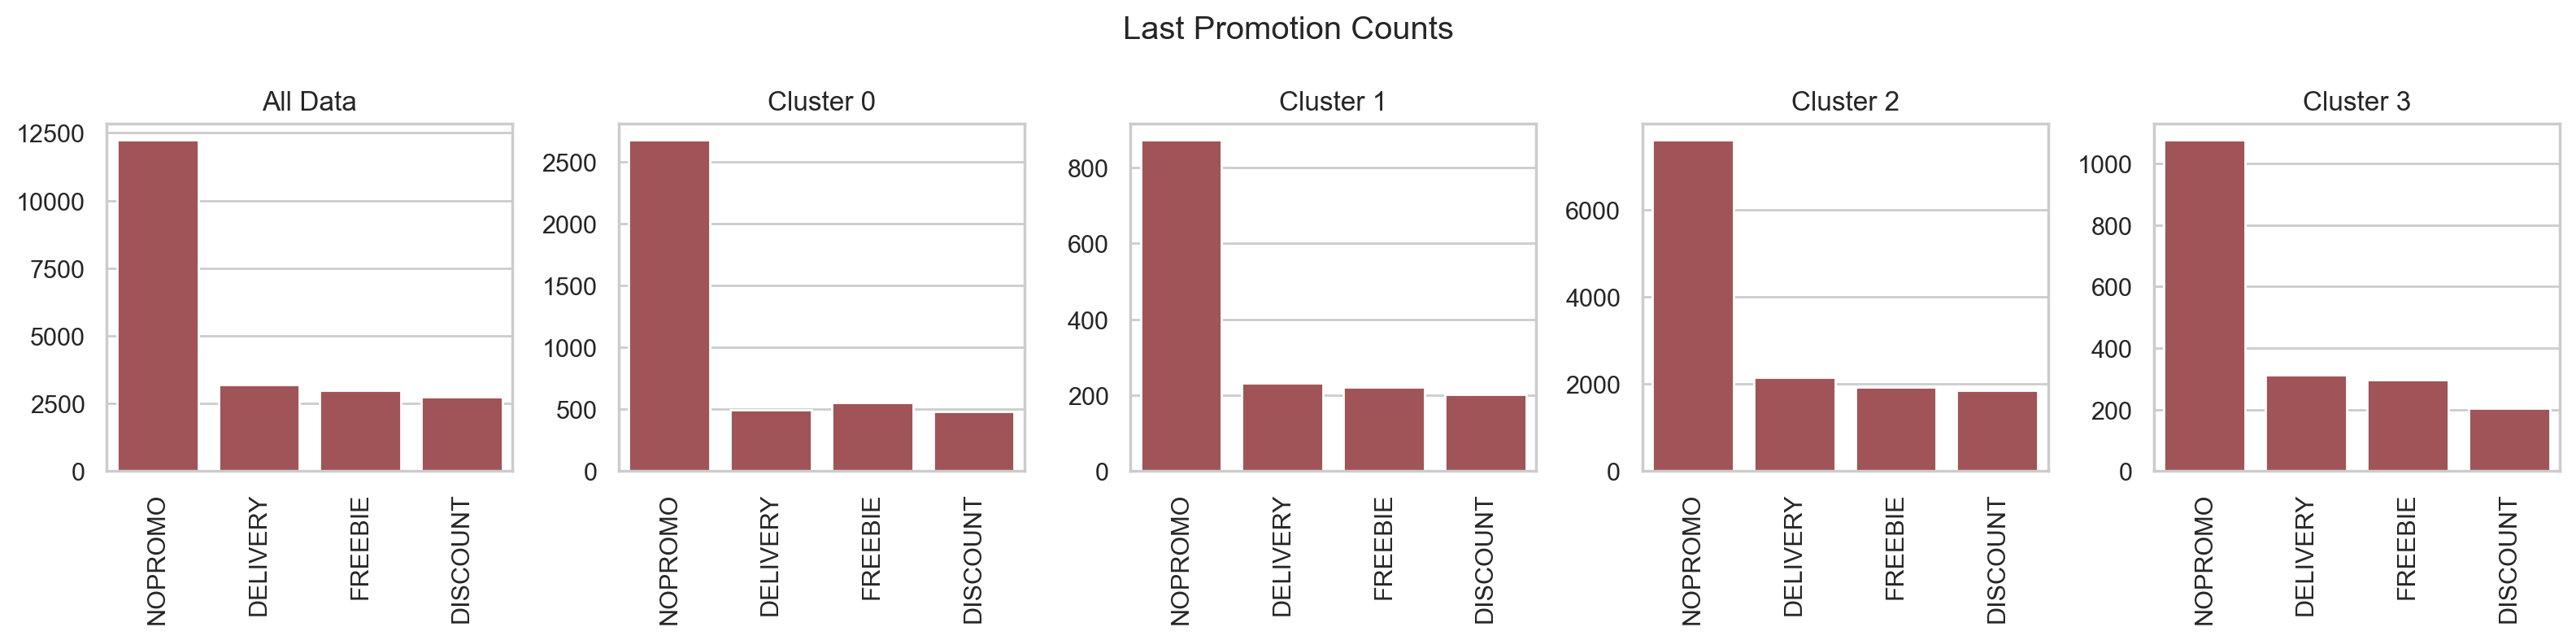

In [153]:
fig, axes = plt.subplots(1, 
                         food_df['merged_labels'].nunique() + 1, # Add an extra ax for population countplot
                         figsize=(16, 4),
                         tight_layout=True,
                        )

for i in range(len(axes.flatten())): 
    ax = axes[i]
    if i == 0:
        sns.countplot(data=food_df, 
                      x='last_promo', 
                      order=food_df['last_promo'].value_counts().index,
                      ax=ax,
                        palette=[colors["PR"]])  

        ax.set_title("All Data")
        
    else:    
        sns.countplot(data=food_df[food_df['merged_labels'] == i-1], 
                      x='last_promo', 
                      order=food_df['last_promo'].value_counts().index,
                      ax=ax,
                    palette=[colors["PR"]])  

        ax.set_title(f"Cluster {i-1}")
    
    ax.tick_params(axis="x", labelrotation=90)
    ax.set_xlabel("")
    ax.set_ylabel("")

plt.suptitle("Last Promotion Counts")
plt.show()

There is no distinct difference in behavior in per type of promotion between the clusters. For all the clusters, the most customers make orders under no promotion.

    Payment Method

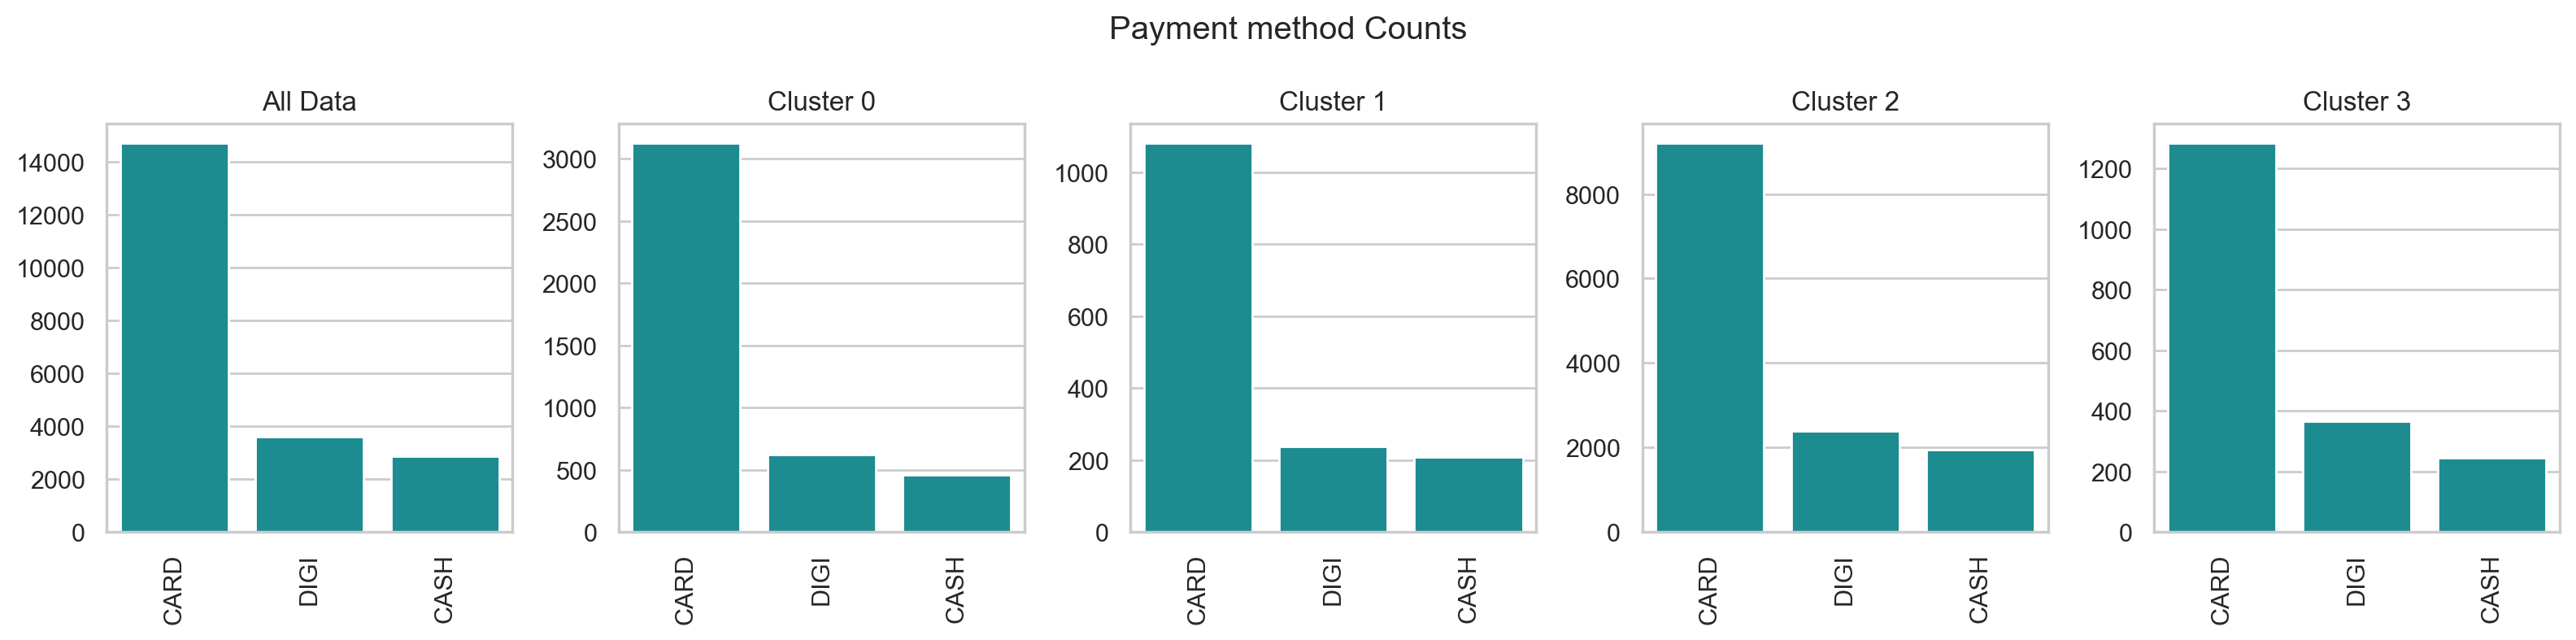

In [154]:
fig, axes = plt.subplots(1, 
                         food_df['merged_labels'].nunique() + 1, # Add an extra ax for population countplot
                         figsize=(16, 4),
                         tight_layout=True,
                        )

for i in range(len(axes.flatten())): 
    ax = axes[i]
    if i == 0:
        sns.countplot(data=food_df, 
                      x='payment_method', 
                      order=food_df['payment_method'].value_counts().index,
                      ax=ax,
                    palette=[colors["BL"]])  

        ax.set_title("All Data")
        
    else:    
        sns.countplot(data=food_df[food_df['merged_labels'] == i-1], 
                      x='payment_method', 
                      order=food_df['payment_method'].value_counts().index,
                      ax=ax,
                        palette=[colors["BL"]])  

        ax.set_title(f"Cluster {i-1}")
    
    ax.tick_params(axis="x", labelrotation=90)
    ax.set_xlabel("")
    ax.set_ylabel("")

plt.suptitle("Payment method Counts")
plt.show()

There is no difference for the payment method.

    Food Diversity Category

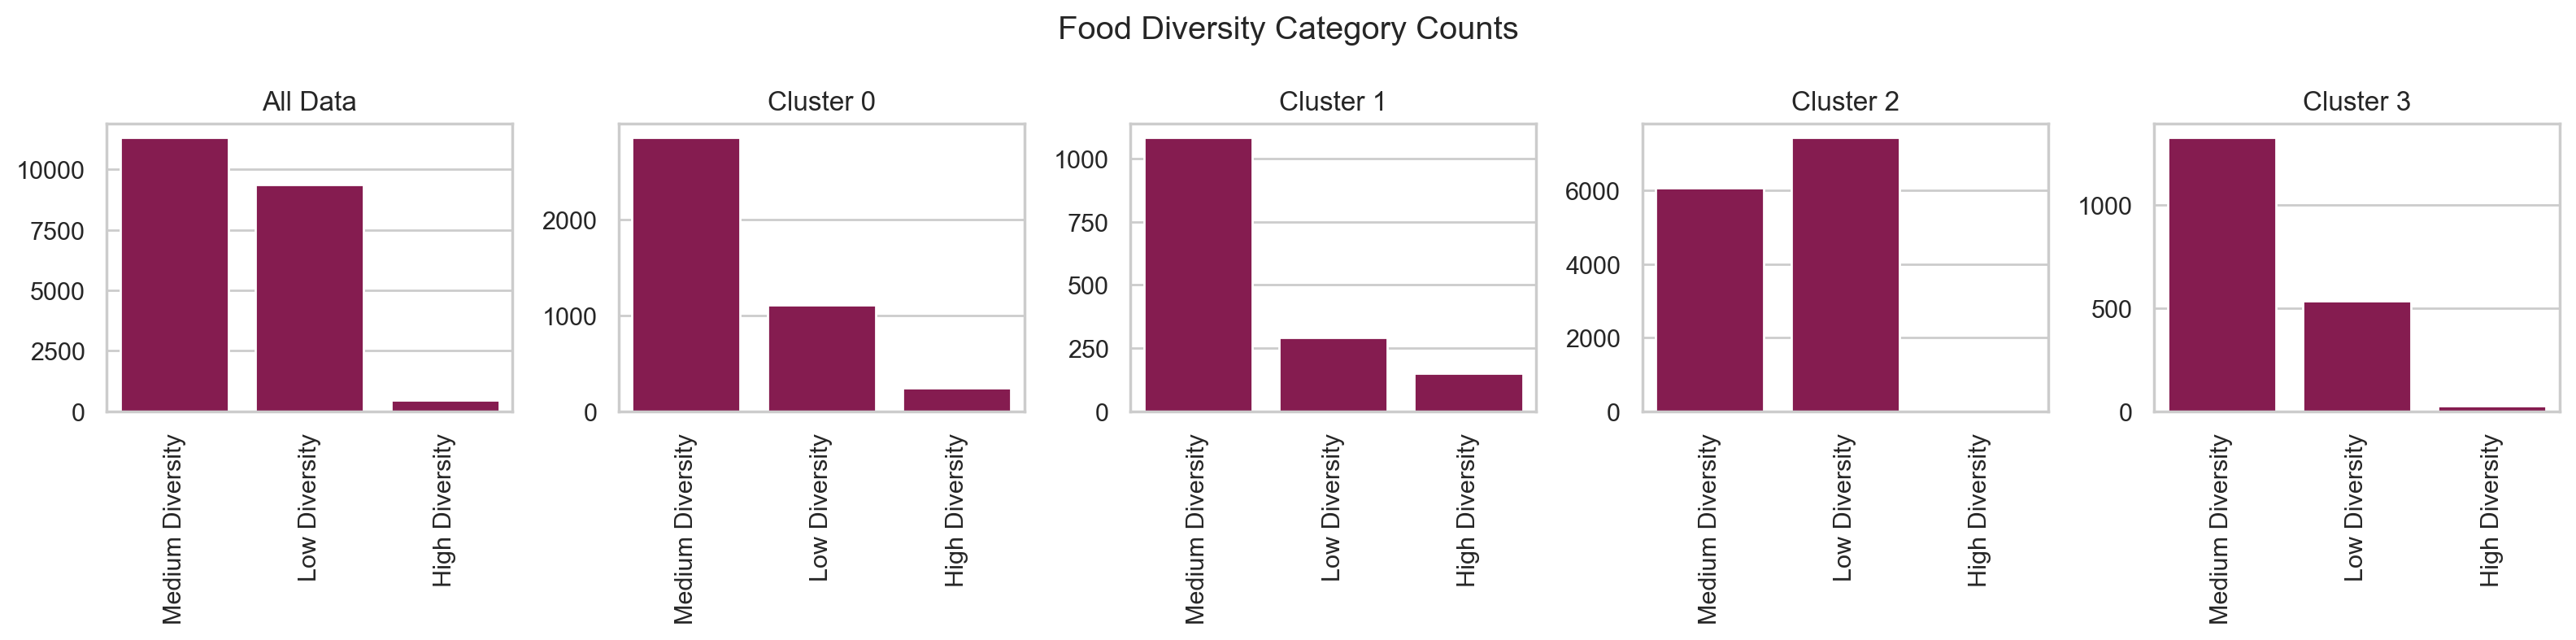

In [155]:
fig, axes = plt.subplots(1, 
                         food_df['merged_labels'].nunique() + 1, # Add an extra ax for population countplot
                         figsize=(16, 4),
                         tight_layout=True,
                        )

for i in range(len(axes.flatten())): 
    ax = axes[i]
    if i == 0:
        sns.countplot(data=food_df, 
                      x='food_diversity_category', 
                      order=food_df['food_diversity_category'].value_counts().index,
                      ax=ax,
                        palette=[colors["M"]])
        ax.set_title("All Data")
        
    else:    
        sns.countplot(data=food_df[food_df['merged_labels'] == i-1], 
                      x='food_diversity_category', 
                      order=food_df['food_diversity_category'].value_counts().index,
                      ax=ax,
                    palette=[colors["M"]])  
        ax.set_title(f"Cluster {i-1}")
    
    ax.tick_params(axis="x", labelrotation=90)
    ax.set_xlabel("")
    ax.set_ylabel("")

plt.suptitle("Food Diversity Category Counts")
plt.show()

- `Cluster 2`: Seems to be the most distinct, as it is the only one that seems to have "Low diversity" as the highest food diversity category.

    Customer Region by Food Diversity

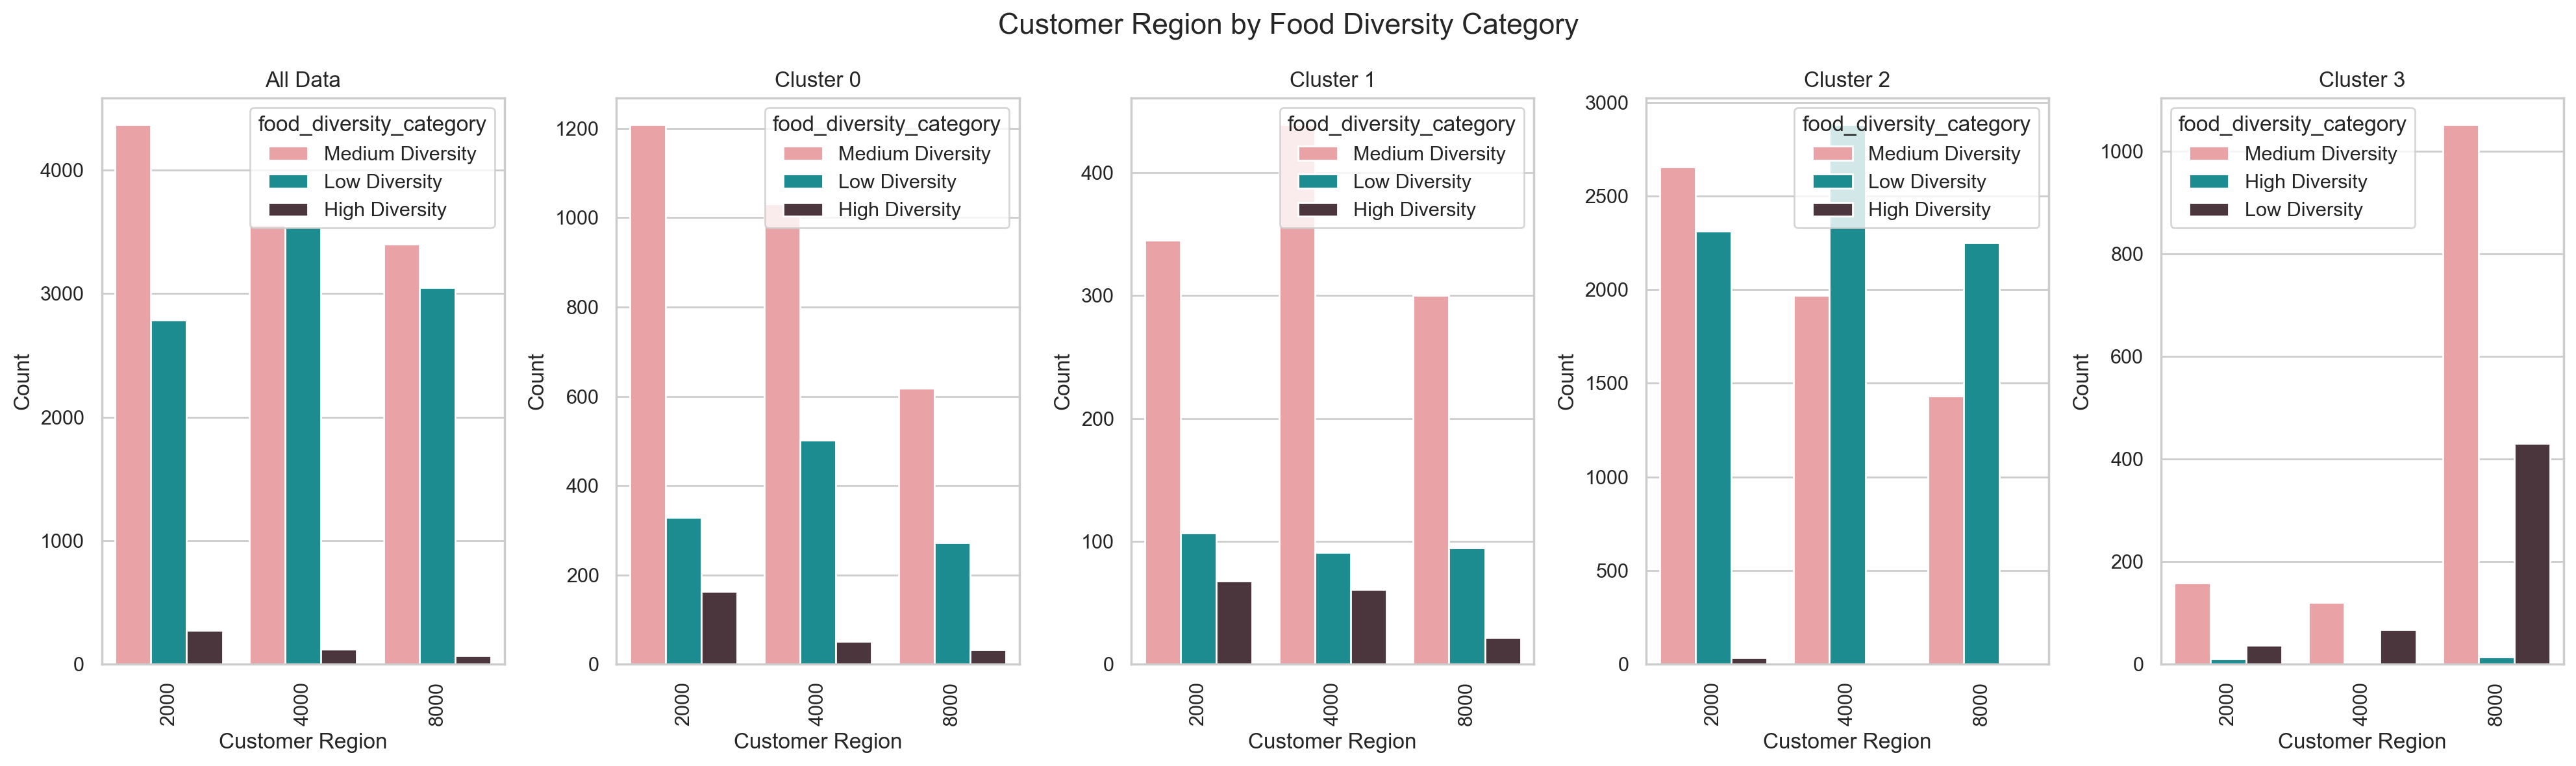

In [156]:

fig, axes = plt.subplots(1, 
                         food_df['merged_labels'].nunique() + 1,  # Add an extra ax for population countplot
                         figsize=(20, 6),
                         tight_layout=True,
                        )

for i, ax in enumerate(axes.flatten()): 
    if i == 0:
        sns.countplot(data=food_df, 
                      x='customer_region', 
                      hue='food_diversity_category',  
                      order=food_df['customer_region'].value_counts().index,
                      ax=ax,
                      palette=custom_palette)
        ax.set_title("All Data")
    else:    
        sns.countplot(data=food_df[food_df['merged_labels'] == i-1], 
                      x='customer_region', 
                      hue='food_diversity_category',  
                      order=food_df['customer_region'].value_counts().index,
                      ax=ax,
                      palette=custom_palette)  
        ax.set_title(f"Cluster {i-1}")
    
    ax.tick_params(axis="x", labelrotation=90)
    ax.set_xlabel("Customer Region")
    ax.set_ylabel("Count")

plt.suptitle("Customer Region by Food Diversity Category", fontsize=16)
plt.show()



From the visualization above, we can observe the follwoing:
- `Cluster 2`: knowing that this is the only cluster that has the highest food diversity as "Low diversity". Here we can see that these are the cases of customers from regions `2000` and `8000`, and for those 2 regions, there is not food diversity "High diversity".
- `Cluster 3`: Although the highest food diversity category for this cluster was the "medium diversity", the region 4000 customr have no "High diversity" category 

    Overall Categorical features

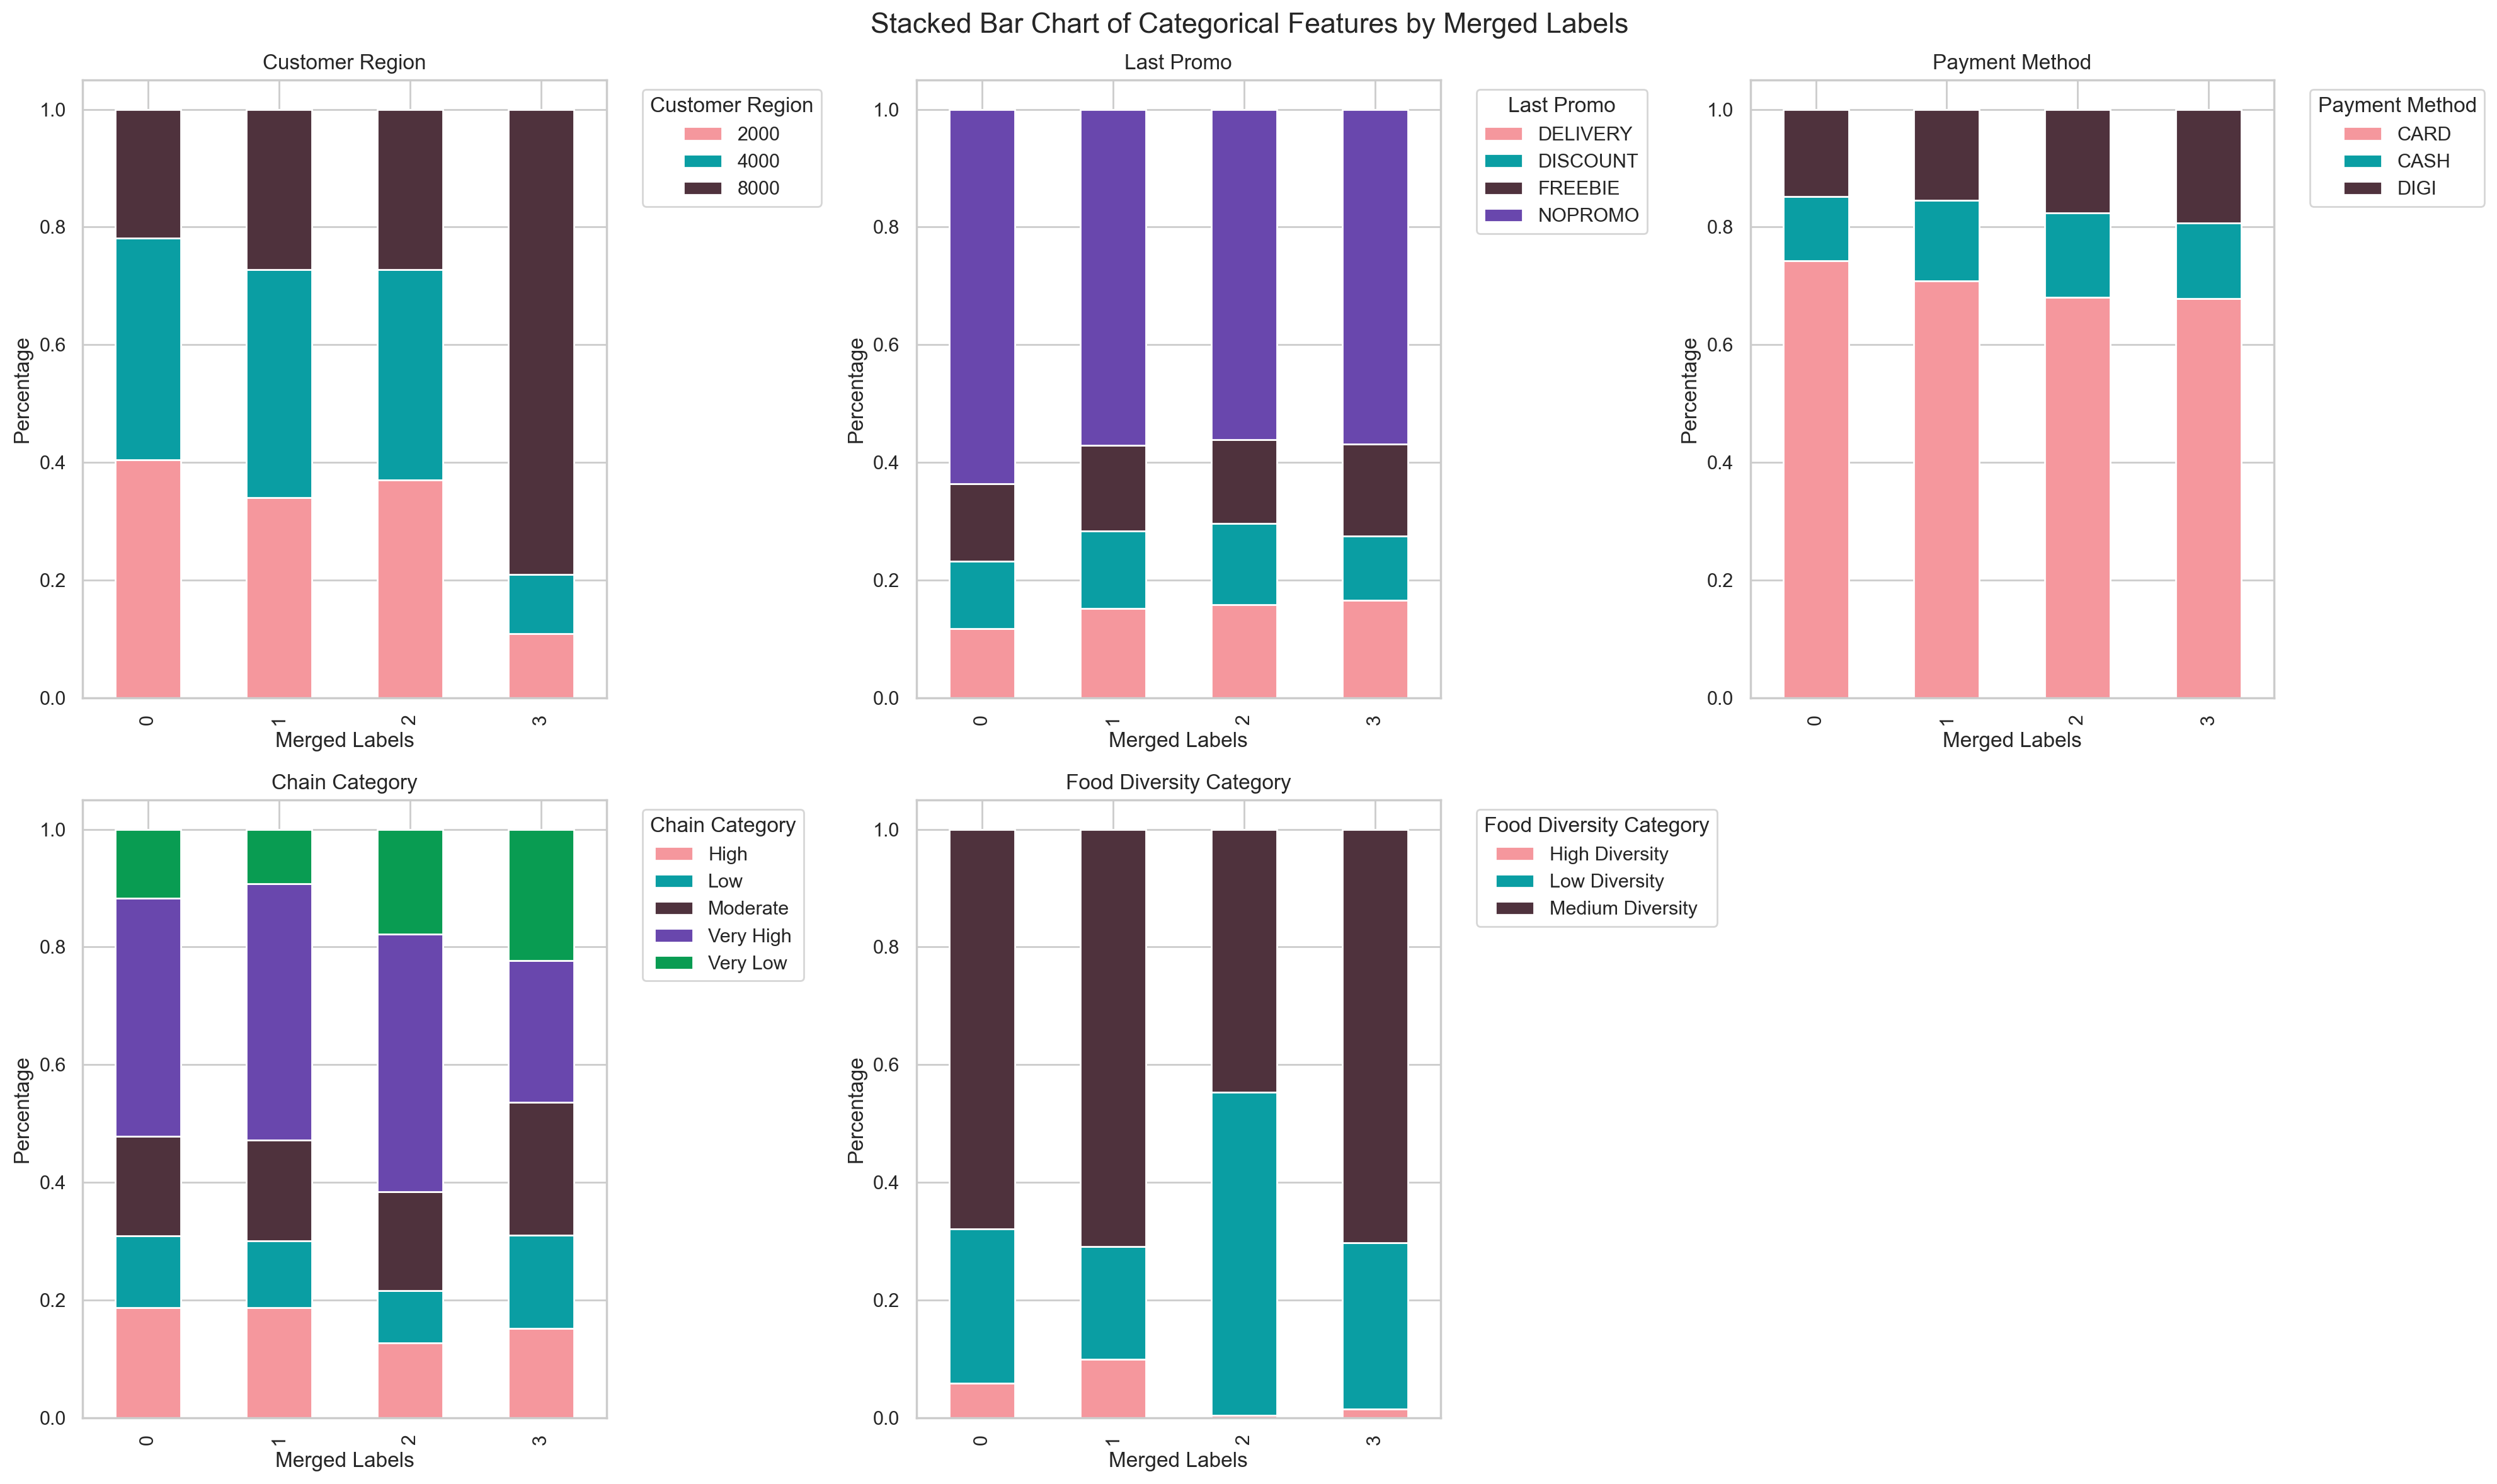

In [157]:
#Defining the categorical features
num_features = len(categorical_features)
n_cols = 3 
n_rows = -(-num_features // n_cols)  #Calculating the number of rows

# Set up the figure and axes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6 * n_rows), tight_layout=True
)
axes = axes.flatten()

# Loop through each categorical feature
for i, feature in enumerate(categorical_features):
    ax = axes[i]

    #Computing percentages for each category within each merged_label
    percentage_data = (
        food_df.groupby('merged_labels')[feature]
        .value_counts(normalize=True)
        .rename('percentage')
        .reset_index()
    )

    pivot_data = percentage_data.pivot(index='merged_labels', columns=feature, values='percentage')

    # Create a stacked bar chart using custom colors
    pivot_data.plot(kind='bar', stacked=True, ax=ax, color=custom_palette)

    ax.set_title(feature.replace('_', ' ').title())
    ax.set_xlabel("Merged Labels")
    ax.set_ylabel("Percentage")
    ax.legend(title=feature.replace('_', ' ').title(), bbox_to_anchor=(1.05, 1), loc='upper left')

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Stacked Bar Chart of Categorical Features by Merged Labels", fontsize=16)
plt.show()


### Cluster Insights and Marketing Strategies

#### **Cluster 0 - Stephanie, the explorer**
**Insights:**
- Spends the most by unique vendors.
- Prefers **Western and Asian cuisines**.
- Highest spending on **Desserts_Beverages**.
- Most active during **evening hours**, with midday and late-night activity as well.
- Highest total orders and total spent, but lowest average spend per order.
- Highest customer lifetime but lowest average days between orders.

**Marketing Strategies:**
1. **Exclusive Offers & Loyalty Programs:** VIP rewards for repeat purchases and early access to new items.
2. **Targeted Promotions:** Highlight discounts and new dishes in Western and Asian cuisines.
3. **Late-Night Flash Sales:** Time-limited offers on desserts and beverages during evening hours.
4. **Bundle Deals:** Family-style or group meal bundles to appeal to high order frequency.
5. **Content Marketing:** Collaborate with food influencers to showcase diverse food experiences.

---

#### **Cluster 1 - Sportacus**
**Insights:**
- Exclusively buys from **CUI_Healthy**.
- Low spending on Asian and Western cuisines.
- Balanced ordering times, slightly favoring late-night hours.
- Second highest in total orders and total spent, but second lowest average spend per order.
- Relatively lower customer lifetime and average days between orders.

**Marketing Strategies:**
1. **Healthy Meal Plans:** Weekly subscriptions with curated healthy options.
2. **Late-Night Health Promotions:** Discounts on late-night healthy snacks and meals.
3. **Customizable Meals:** Build-your-own meal options for personalization.
4. **Nutritional Education:** Highlight the benefits of healthy eating through campaigns.
5. **Social Media Collaborations:** Partner with fitness influencers to promote healthy lifestyles.

---

#### **Cluster 2 - Pixel, the Night Owl**
**Insights:**
- Spends less on unique vendors.
- Does not spend on **CUI_Healthy** or **CUI_Street Food/Snacks**.
- Orders mostly during **late-night hours** on both weekdays and weekends.
- Lowest customer lifetime but high average days between orders.

**Marketing Strategies:**
1. **Late-Night Promotions:** Special discounts for orders placed after midnight.
2. **Snack Packs:** Quick bites and comfort foods for casual late-night cravings.
3. **Push Notifications:** Time-specific reminders to trigger purchases.
4. **Limited-Time Menus:** Seasonal or exclusive menu items for night owls.
5. **Occasional Engagement:** Incentives for less frequent customers to return.

---

#### **Cluster 3 - Robin Rotten, the Snacker**
**Insights:**
- Spends the most on **CUI_Street Food/Snacks**.
- No spending on **CUI_Healthy**.
- Lowest spending on Western and Asian cuisines.
- Orders primarily during **late-night hours** on weekdays.
- Second highest total spent, with the highest average spend per order.
- Low customer lifetime but high average days between orders.

**Marketing Strategies:**
1. **Street Food Campaigns:** Highlight authentic street food experiences.
2. **Late-Night Specials:** Discounts on street food orders after 10 PM.
3. **Pop-Up Events:** Partner with street food vendors for exclusive events.
4. **Bundled Offers:** Large "Street Food Feast" bundles for high-spending customers.
5. **Gamification:** Reward points for late-night or large street food orders.

---

These markting strategies listed above, are ideas. In the project report we will have the final marketing straegies for each persona.